In [1]:
!pip install transformers torch matplotlib seaborn pandas gradio duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering
import textwrap
import json
import re

In [3]:
# Set up plotting style
sns.set(style='darkgrid')
sns.set(font_scale=1.2)
plt.rcParams["figure.figsize"] = (16, 8)

# Load the AraELECTRA model fine-tuned for Arabic question answering
model_name = "ZeyadAhmed/AraElectra-Arabic-SQuADv2-QA"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Create a question-answering pipeline
qa_pipeline = pipeline(
    "question-answering",
    model=model,
    tokenizer=tokenizer
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/761k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/538M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

Device set to use cpu


In [4]:
# ===============================
# PROMPT ENGINEERING COMPONENTS
# ===============================

class ArabicQAPromptEngineer:
    """
    Advanced prompt engineering class for Arabic Question Answering
    """

    def __init__(self):
        self.question_templates = {
            'direct': "السؤال: {question}\nالسياق: {context}\nالإجابة:",
            'formal': "بناءً على النص التالي، أجب على السؤال:\nالنص: {context}\nالسؤال: {question}\nالإجابة المطلوبة:",
            'detailed': "اقرأ النص التالي بعناية ثم أجب على السؤال بدقة:\n\nالنص المرجعي:\n{context}\n\nالسؤال المطروح:\n{question}\n\nالإجابة الصحيحة:",
            'contextual': "استخدم المعلومات الواردة في النص أدناه للإجابة على السؤال:\n\nالمحتوى:\n{context}\n\nالاستفسار:\n{question}\n\nالرد:",
            'analytical': "حلل النص التالي واستخرج الإجابة المناسبة للسؤال:\n\nالنص للتحليل:\n{context}\n\nالسؤال التحليلي:\n{question}\n\nالاستنتاج:"
        }

        self.question_enhancers = {
            'specificity': ['تحديداً', 'بالضبط', 'على وجه التحديد'],
            'emphasis': ['بوضوح', 'صراحة', 'تماماً'],
            'precision': ['دقيقاً', 'محدداً', 'واضحاً'],
            'completeness': ['كاملاً', 'شاملاً', 'مفصلاً']
        }

        self.context_preprocessors = {
            'clean': self._clean_context,
            'structure': self._structure_context,
            'highlight': self._highlight_keywords,
            'segment': self._segment_context
        }

    def _clean_context(self, context):
        """Clean and normalize Arabic text"""
        # Remove extra whitespaces
        context = re.sub(r'\s+', ' ', context)
        # Normalize Arabic characters
        context = context.replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا')
        context = context.replace('ة', 'ه').replace('ى', 'ي')
        return context.strip()

    def _structure_context(self, context):
        """Add structure markers to context"""
        sentences = context.split('.')
        structured = ""
        for i, sentence in enumerate(sentences, 1):
            if sentence.strip():
                structured += f"[{i}] {sentence.strip()}. "
        return structured

    def _highlight_keywords(self, context, question):
        """Highlight potential keywords in context"""
        question_words = question.split()
        highlighted_context = context
        for word in question_words:
            if len(word) > 3:  # Only highlight meaningful words
                highlighted_context = highlighted_context.replace(
                    word, f"**{word}**"
                )
        return highlighted_context

    def _segment_context(self, context):
        """Segment context into logical parts"""
        segments = context.split('،')
        segmented = ""
        for i, segment in enumerate(segments, 1):
            if segment.strip():
                segmented += f"الجزء {i}: {segment.strip()}.\n"
        return segmented

    def enhance_question(self, question, enhancement_type='specificity'):
        """Enhance question with specific modifiers"""
        enhancers = self.question_enhancers.get(enhancement_type, [''])
        enhanced = f"{question} {enhancers[0]}"
        return enhanced

    def preprocess_context(self, context, method='clean'):
        """Preprocess context using specified method"""
        processor = self.context_preprocessors.get(method, self._clean_context)
        return processor(context)

    def create_prompt(self, question, context, template_type='detailed',
                     question_enhancement=None, context_preprocessing='clean'):
        """Create enhanced prompt for QA"""

        # Preprocess context
        processed_context = self.preprocess_context(context, context_preprocessing)

        # Enhance question if specified
        if question_enhancement:
            enhanced_question = self.enhance_question(question, question_enhancement)
        else:
            enhanced_question = question

        # Apply template
        template = self.question_templates.get(template_type, self.question_templates['direct'])
        prompt = template.format(question=enhanced_question, context=processed_context)

        return prompt, enhanced_question, processed_context

    def multi_prompt_inference(self, question, context, qa_pipeline):
        """Run inference with multiple prompt strategies"""
        results = {}

        strategies = [
            ('direct', None, 'clean'),
            ('formal', 'specificity', 'clean'),
            ('detailed', 'precision', 'structure'),
            ('contextual', 'emphasis', 'highlight'),
            ('analytical', 'completeness', 'segment')
        ]

        for template_type, enhancement, preprocessing in strategies:
            try:
                prompt, enhanced_q, processed_ctx = self.create_prompt(
                    question, context, template_type, enhancement, preprocessing
                )

                # For transformers pipeline, we still use original format
                result = qa_pipeline(question=enhanced_q, context=processed_ctx)

                results[f"{template_type}_{enhancement}_{preprocessing}"] = {
                    'prompt': prompt,
                    'enhanced_question': enhanced_q,
                    'processed_context': processed_ctx,
                    'answer': result['answer'],
                    'confidence': result['score'],
                    'start': result['start'],
                    'end': result['end']
                }
            except Exception as e:
                print(f"Error with strategy {template_type}: {e}")
                continue

        return results

    def select_best_answer(self, multi_results):
        """Select best answer from multiple prompt results"""
        if not multi_results:
            return None

        # Sort by confidence score
        sorted_results = sorted(
            multi_results.items(),
            key=lambda x: x[1]['confidence'],
            reverse=True
        )

        best_strategy, best_result = sorted_results[0]

        # Create ensemble answer if multiple high-confidence results
        high_conf_results = [r for _, r in sorted_results if r['confidence'] > 0.8]

        if len(high_conf_results) > 1:
            # Check for answer consistency
            answers = [r['answer'] for r in high_conf_results]
            if len(set(answers)) == 1:  # All answers are the same
                best_result['ensemble_confidence'] = sum(r['confidence'] for r in high_conf_results) / len(high_conf_results)
                best_result['strategy_used'] = 'ensemble_consistent'
            else:
                best_result['strategy_used'] = 'highest_confidence'
        else:
            best_result['strategy_used'] = best_strategy

        return best_result


In [5]:
# Initialize prompt engineer
prompt_engineer = ArabicQAPromptEngineer()

In [6]:
# ===============================
# ENHANCED QA FUNCTION WITH PROMPTS
# ===============================

def enhanced_answer_question(question, context, use_prompt_engineering=True):
    """
    Enhanced question answering function with prompt engineering
    """
    print(f"Question: {question}")
    print(f"Context length: {len(context)} characters")
    print("-" * 50)

    if use_prompt_engineering:
        print("🚀 Using Advanced Prompt Engineering...")

        # Multi-prompt inference
        multi_results = prompt_engineer.multi_prompt_inference(question, context, qa_pipeline)

        if multi_results:
            # Display all strategy results
            print(f"📊 Generated {len(multi_results)} different prompt strategies:")
            for strategy, result in multi_results.items():
                print(f"  • {strategy}: {result['answer']} (confidence: {result['confidence']:.4f})")

            # Select best answer
            best_result = prompt_engineer.select_best_answer(multi_results)

            if best_result:
                print(f"\n🎯 Best Answer Selected:")
                print(f"Answer: {best_result['answer']}")
                print(f"Confidence: {best_result['confidence']:.4f}")
                print(f"Strategy Used: {best_result['strategy_used']}")

                if 'ensemble_confidence' in best_result:
                    print(f"Ensemble Confidence: {best_result['ensemble_confidence']:.4f}")

                return best_result

        print("⚠️ Prompt engineering failed, falling back to standard method...")

    # Standard method (fallback)
    print("📝 Using Standard Method...")
    result = qa_pipeline(question=question, context=context)
    print(f"Answer: {result['answer']}")
    print(f"Confidence: {result['score']:.4f}")

    return result

In [7]:
# ===============================
# ORIGINAL CODE WITH PROMPT INTEGRATION
# ===============================

# Test with original Baghdad example - NOW WITH PROMPT ENGINEERING
question = "من هو مؤسس مدينة بغداد؟"
context = """
إن مؤسس مدينة بغداد هو الخليفة العباسي أبو جعفر المنصور. قام بتأسيس المدينة في القرن الثاني الهجري،
والذي يوافق القرن الثامن الميلادي، في عام 145 هـ. بعد اكتمال بناء المدينة، اختارها أبو جعفر المنصور لتكون
عاصمة لدولة الخلافة العباسية.
"""

print("=" * 70)
print("ENHANCED QA WITH PROMPT ENGINEERING")
print("=" * 70)

# Enhanced method with prompt engineering
enhanced_result = enhanced_answer_question(question, context, use_prompt_engineering=True)

print("\n" + "=" * 50)
print("COMPARISON WITH STANDARD METHOD")
print("=" * 50)

# Standard method for comparison
standard_result = enhanced_answer_question(question, context, use_prompt_engineering=False)

print("-" * 50)

ENHANCED QA WITH PROMPT ENGINEERING
Question: من هو مؤسس مدينة بغداد؟
Context length: 237 characters
--------------------------------------------------
🚀 Using Advanced Prompt Engineering...
Error with strategy contextual: ArabicQAPromptEngineer._highlight_keywords() missing 1 required positional argument: 'question'
📊 Generated 4 different prompt strategies:
  • direct_None_clean: الخليفه العباسي ابو جعفر المنصور (confidence: 0.5294)
  • formal_specificity_clean: الخليفه العباسي ابو جعفر المنصور (confidence: 0.5704)
  • detailed_precision_structure: الخليفة العباسي أبو جعفر المنصور (confidence: 0.6588)
  • analytical_completeness_segment: الخليفة العباسي أبو جعفر المنصور (confidence: 0.6101)

🎯 Best Answer Selected:
Answer: الخليفة العباسي أبو جعفر المنصور
Confidence: 0.6588
Strategy Used: detailed_precision_structure

COMPARISON WITH STANDARD METHOD
Question: من هو مؤسس مدينة بغداد؟
Context length: 237 characters
--------------------------------------------------
📝 Using Standard Met

In [8]:
# Method 2: Manual approach for detailed analysis and visualization
print("Method 2: Manual Approach with Visualization")

# Tokenize the question and context
inputs = tokenizer.encode_plus(
    question,
    context,
    add_special_tokens=True,
    return_tensors='pt',
    max_length=512,
    truncation=True,
    padding=True,
    return_token_type_ids=True
)

input_ids = inputs['input_ids'][0]
token_type_ids = inputs['token_type_ids'][0]
tokens = tokenizer.convert_ids_to_tokens(input_ids)

print(f'The input has a total of {len(input_ids)} tokens.')
print("\nTokenization breakdown:")

Method 2: Manual Approach with Visualization
The input has a total of 54 tokens.

Tokenization breakdown:


In [9]:
# Display tokens with their IDs and segments
for i, (token, id, segment) in enumerate(zip(tokens, input_ids, token_type_ids)):
    if token == tokenizer.sep_token:
        print('')

    segment_label = "Question" if segment == 0 else "Context"
    print(f'{token:<15} {id:>6} ({segment_label})')

    if token == tokenizer.sep_token:
        print('')

# Run the model
with torch.no_grad():
    outputs = model(**inputs)

start_logits = outputs.start_logits[0]
end_logits = outputs.end_logits[0]

# Find the best start and end positions
answer_start = torch.argmax(start_logits)
answer_end = torch.argmax(end_logits)

print(f"\nPredicted start position: {answer_start}")
print(f"Predicted end position: {answer_end}")

# Extract and clean the answer
answer_tokens = tokens[answer_start:answer_end+1]
answer = tokenizer.convert_tokens_to_string(answer_tokens)

print(f'Raw answer tokens: {answer_tokens}')
print(f'Final Answer: "{answer}"')

# Calculate confidence scores
start_score = torch.softmax(start_logits, dim=0)[answer_start].item()
end_score = torch.softmax(end_logits, dim=0)[answer_end].item()
confidence = (start_score + end_score) / 2

print(f'Confidence Score: {confidence:.4f}')

print("-" * 50)

[CLS]                2 (Question)
من                 306 (Question)
هو                 583 (Question)
مؤسس             10611 (Question)
مدينة             1171 (Question)
بغداد             3112 (Question)
؟                  105 (Question)

[SEP]                3 (Question)

إن                 476 (Context)
مؤسس             10611 (Context)
مدينة             1171 (Context)
بغداد             3112 (Context)
هو                 583 (Context)
الخليفة          12280 (Context)
العباسي          29743 (Context)
أبو               1195 (Context)
جعفر              9501 (Context)
المنصور          17647 (Context)
.                   20 (Context)
قام               1178 (Context)
بتأسيس           22077 (Context)
المدينة           1665 (Context)
في                 305 (Context)
القرن             2890 (Context)
الثاني            1161 (Context)
الهجري           27231 (Context)
،                  103 (Context)
والذي             1619 (Context)
يوافق            12423 (Context)
القرن             2890 (Context)


In [10]:
print("Starting Visualization...")

# Convert logits to numpy arrays for visualization
start_scores = start_logits.detach().numpy().flatten()
end_scores = end_logits.detach().numpy().flatten()

# Create token labels with indices, filtering out special tokens for visualization
filtered_token_labels = []
filtered_start_scores = []
filtered_end_scores = []

for i, token in enumerate(tokens):
    if token not in [tokenizer.pad_token, tokenizer.sep_token, tokenizer.cls_token]:
        filtered_token_labels.append(f"{token} - {i}")
        filtered_start_scores.append(start_scores[i])
        filtered_end_scores.append(end_scores[i])


Starting Visualization...


<ipython-input-11-2783662850>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="center")


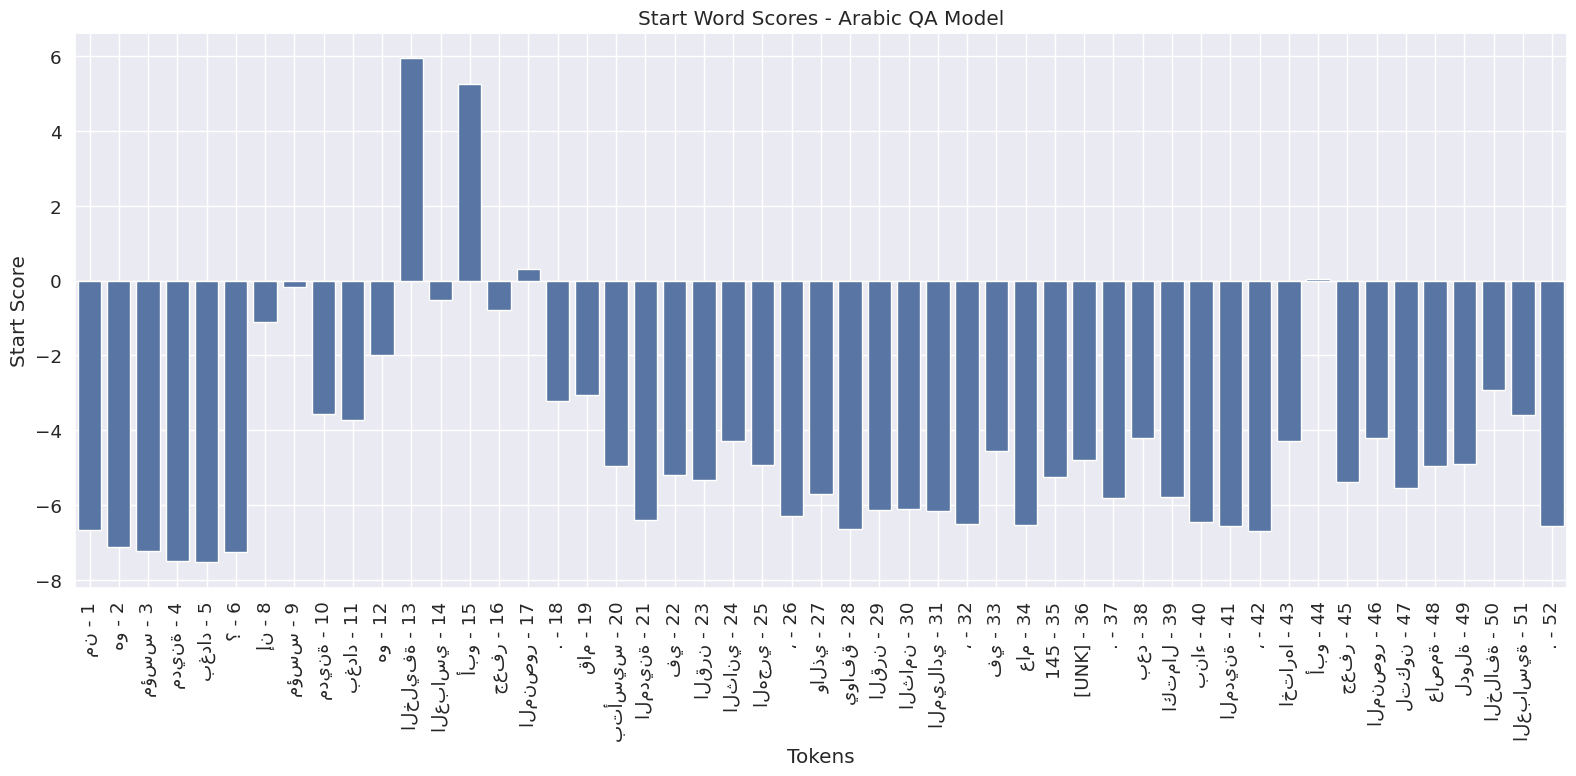

In [11]:
# Visualization 1: Start Word Scores
plt.figure(figsize=(16, 8))
ax1 = sns.barplot(x=filtered_token_labels, y=filtered_start_scores, errorbar=None)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="center")
ax1.grid(True)
plt.title('Start Word Scores - Arabic QA Model')
plt.xlabel('Tokens')
plt.ylabel('Start Score')
plt.tight_layout()
plt.show()


<ipython-input-12-355071152>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha="center")


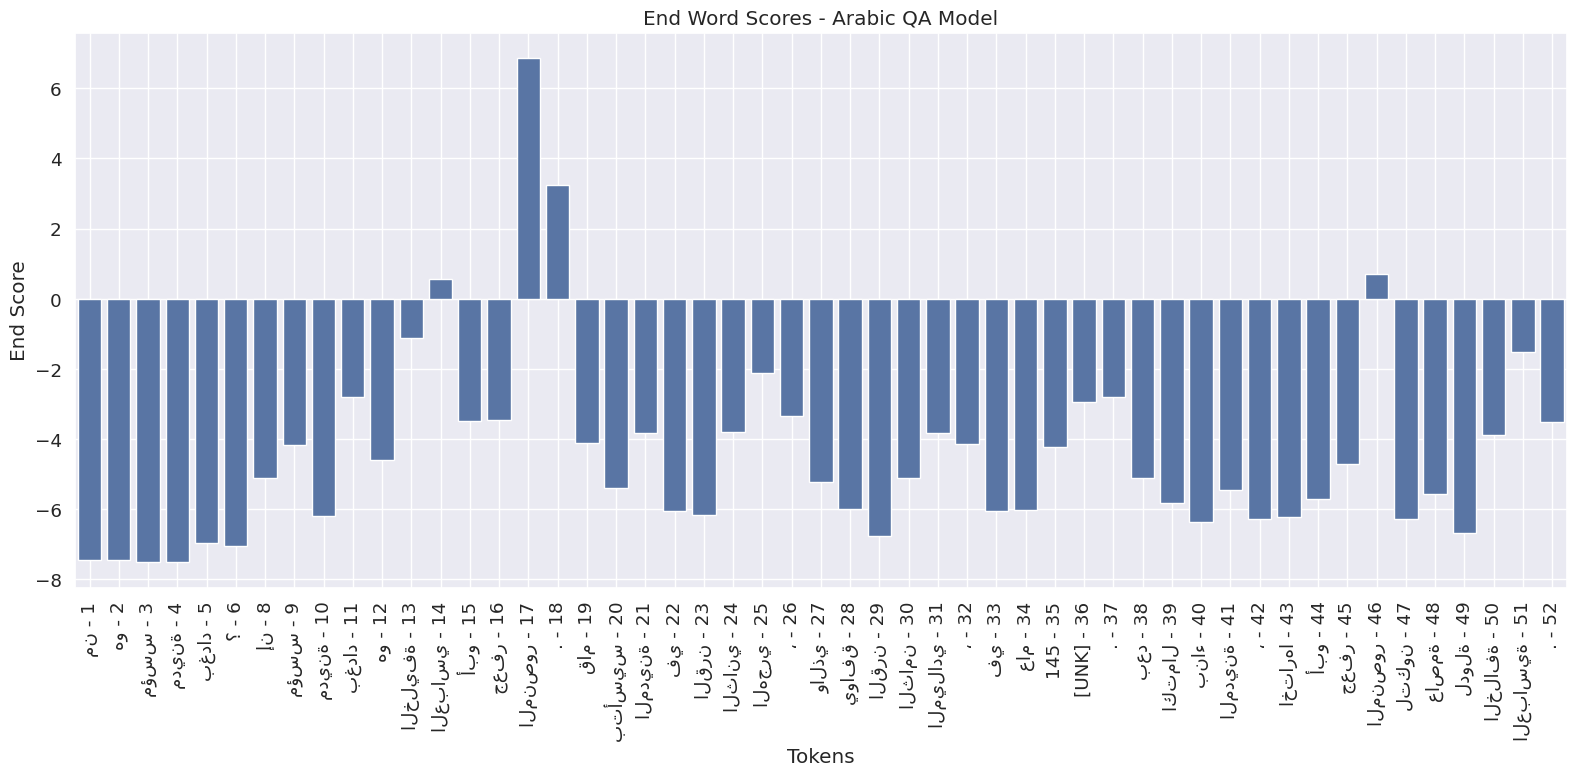

In [12]:
# Visualization 2: End Word Scores
plt.figure(figsize=(16, 8))
ax2 = sns.barplot(x=filtered_token_labels, y=filtered_end_scores, errorbar=None)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha="center")
ax2.grid(True)
plt.title('End Word Scores - Arabic QA Model')
plt.xlabel('Tokens')
plt.ylabel('End Score')
plt.tight_layout()
plt.show()


DataFrame Preview:
  token_label     score marker
0      من - 1 -6.656895  start
1      من - 1 -7.450588    end
2      هو - 2 -7.127481  start
3      هو - 2 -7.457358    end
4    مؤسس - 3 -7.220866  start
5    مؤسس - 3 -7.512947    end
6   مدينة - 4 -7.490892  start
7   مدينة - 4 -7.494064    end
8   بغداد - 5 -7.533825  start
9   بغداد - 5 -6.962879    end


<ipython-input-13-3306730343>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="center", fontsize=10)


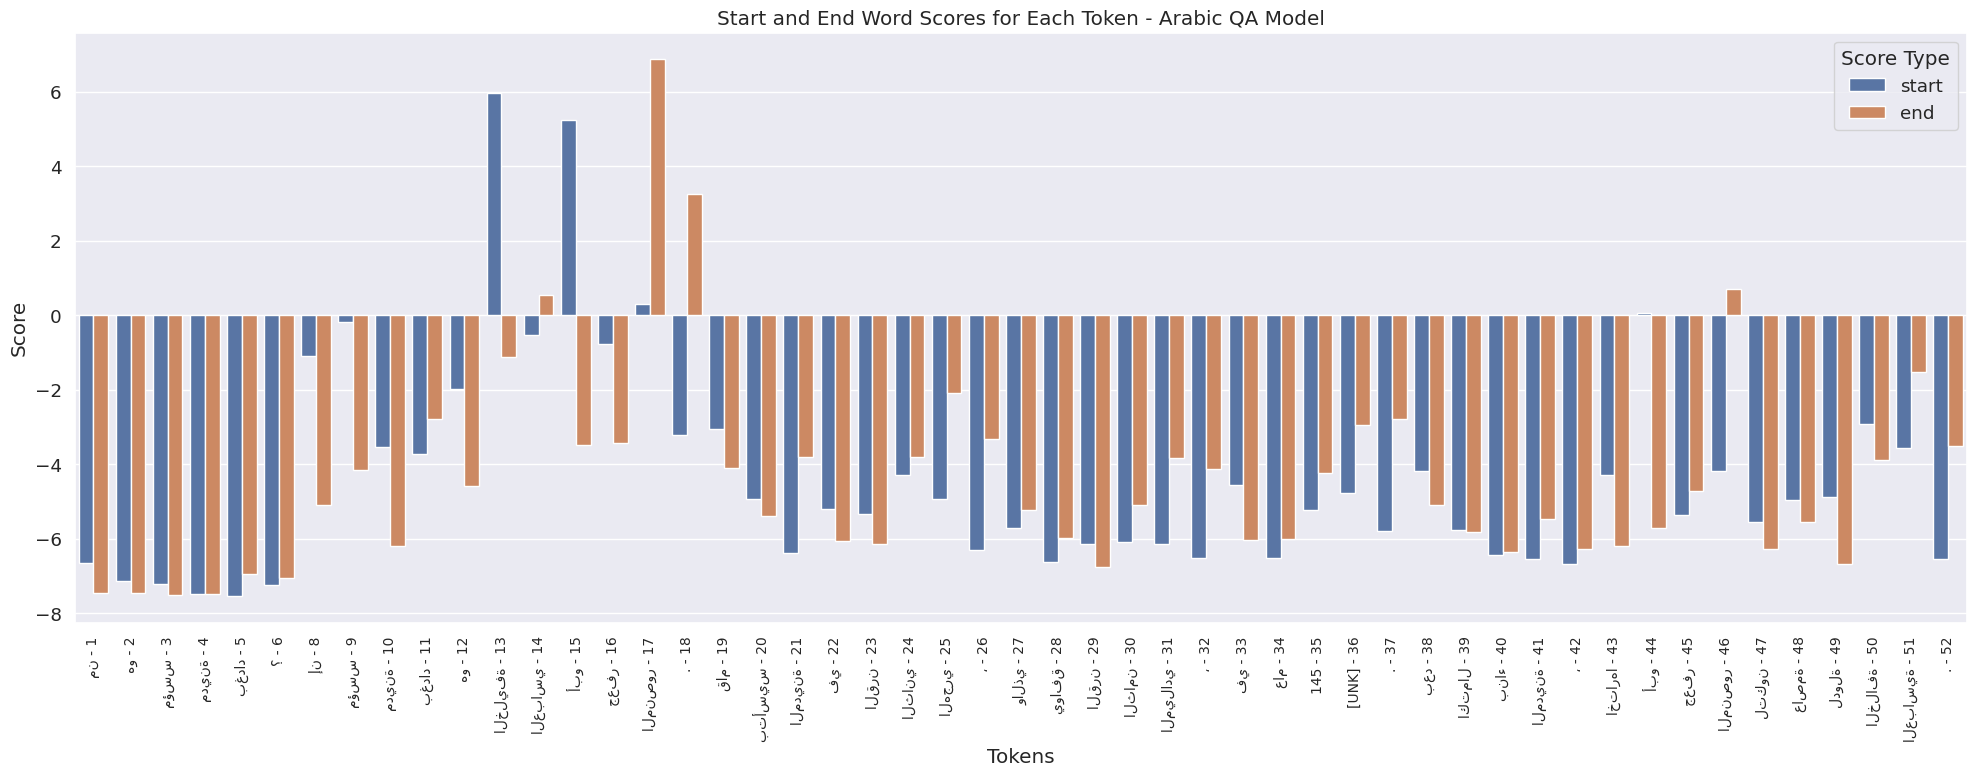

In [13]:
# Visualization 3: Combined Start and End Scores
scores_data = []

for i, token_label in enumerate(filtered_token_labels):
    # Add start score
    scores_data.append({
        'token_label': token_label,
        'score': filtered_start_scores[i],
        'marker': 'start'
    })

    # Add end score
    scores_data.append({
        'token_label': token_label,
        'score': filtered_end_scores[i],
        'marker': 'end'
    })

# Create DataFrame
df = pd.DataFrame(scores_data)

# Show first few rows
print("\nDataFrame Preview:")
print(df.head(10))

# Create grouped barplot
plt.figure(figsize=(20, 8))
g = sns.barplot(data=df, x="token_label", y="score", hue="marker", errorbar=None)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="center", fontsize=10)
g.grid(True, axis="y")
plt.title('Start and End Word Scores for Each Token - Arabic QA Model')
plt.xlabel('Tokens')
plt.ylabel('Score')
plt.legend(title='Score Type')
plt.tight_layout()
plt.show()


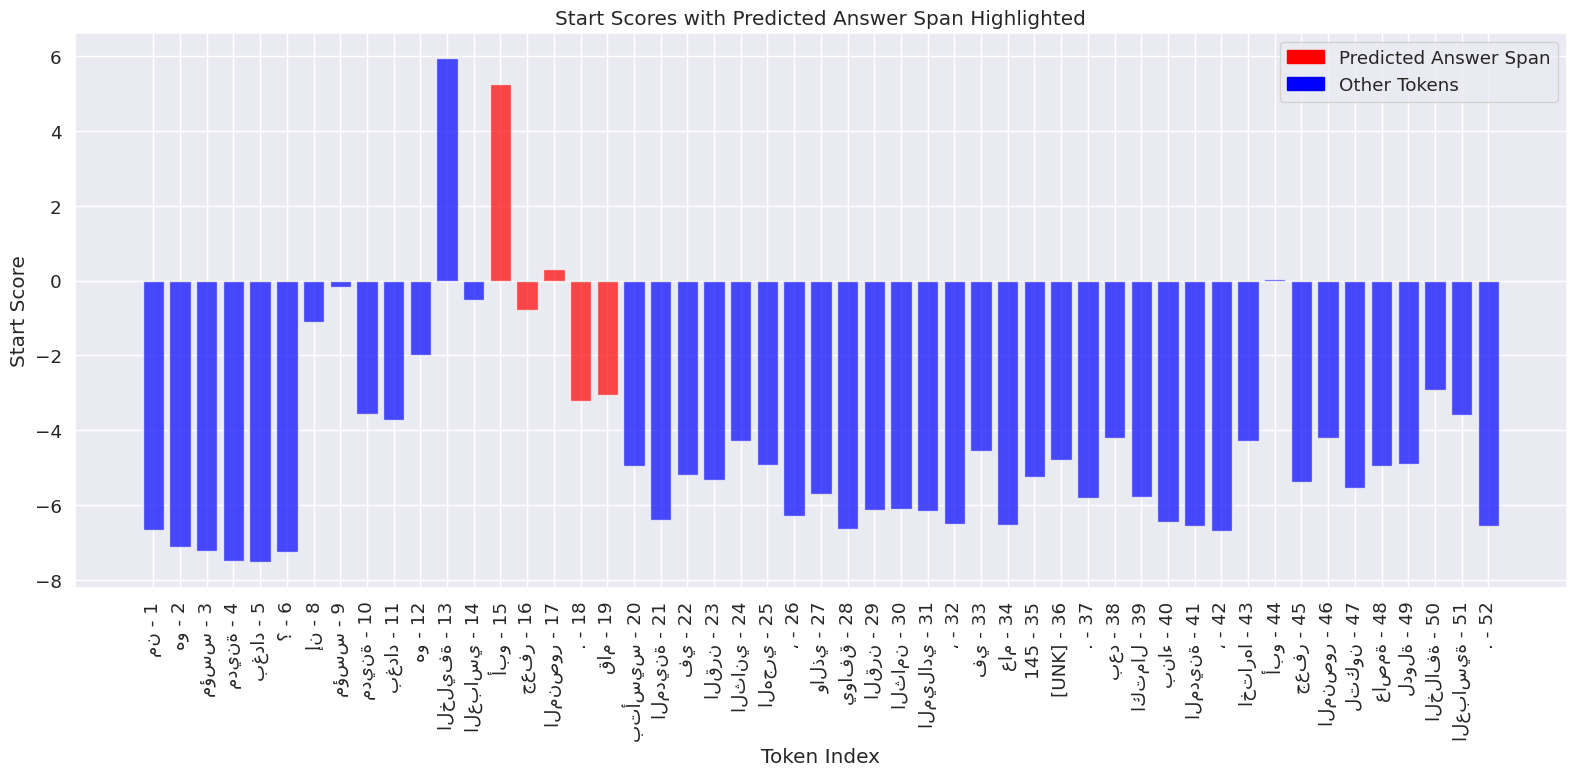

--------------------------------------------------


In [14]:
# Visualization 4: Highlight the predicted answer span
plt.figure(figsize=(16, 8))
colors = ['red' if answer_start <= i <= answer_end else 'blue'
          for i in range(len(filtered_start_scores))]

bars = plt.bar(range(len(filtered_token_labels)), filtered_start_scores, color=colors, alpha=0.7)
plt.title('Start Scores with Predicted Answer Span Highlighted')
plt.xlabel('Token Index')
plt.ylabel('Start Score')
plt.xticks(range(len(filtered_token_labels)), filtered_token_labels, rotation=90, ha="center")
plt.grid(True, axis="y")

# Add legend
import matplotlib.patches as mpatches
answer_patch = mpatches.Patch(color='red', label='Predicted Answer Span')
other_patch = mpatches.Patch(color='blue', label='Other Tokens')
plt.legend(handles=[answer_patch, other_patch])
plt.tight_layout()
plt.show()

print("-" * 50)

In [15]:
# Test with additional questions - NOW WITH PROMPT ENGINEERING
print("Testing with additional questions using PROMPT ENGINEERING:")

questions = [
    "في أي عام تم تأسيس مدينة بغداد؟",
    "في أي قرن تم بناء مدينة بغداد؟",
    "من اختار مدينة بغداد لتكون عاصمة الخلافة العباسية؟"
]

for i, q in enumerate(questions, 1):
    print(f"\n--- Question {i} ---")
    enhanced_answer_question(q, context, use_prompt_engineering=True)

print("Visualization and analysis complete!")

print("=" * 70)
print("ENHANCED QUESTION ANSWERING FUNCTION WITH PROMPTS")
print("=" * 70)

Testing with additional questions using PROMPT ENGINEERING:

--- Question 1 ---
Question: في أي عام تم تأسيس مدينة بغداد؟
Context length: 237 characters
--------------------------------------------------
🚀 Using Advanced Prompt Engineering...
Error with strategy contextual: ArabicQAPromptEngineer._highlight_keywords() missing 1 required positional argument: 'question'
📊 Generated 4 different prompt strategies:
  • direct_None_clean: 145 (confidence: 0.6536)
  • formal_specificity_clean: 145 (confidence: 0.8449)
  • detailed_precision_structure: 145 (confidence: 0.7886)
  • analytical_completeness_segment: القرن الثاني الهجري (confidence: 0.1542)

🎯 Best Answer Selected:
Answer: 145
Confidence: 0.8449
Strategy Used: formal_specificity_clean

--- Question 2 ---
Question: في أي قرن تم بناء مدينة بغداد؟
Context length: 237 characters
--------------------------------------------------
🚀 Using Advanced Prompt Engineering...
Error with strategy contextual: ArabicQAPromptEngineer._highlight_ke

In [16]:
def answer_question(question1, answer_text2):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    print(f"Question: {question1}")
    print(f"Context length: {len(answer_text2)} characters")
    print("-" * 50)

    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question1, answer_text2,
                                add_special_tokens=True,
                                max_length=512,
                                truncation=True)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token itself.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    print(f"Segment A (Question) tokens: {num_seg_a}")
    print(f"Segment B (Context) tokens: {num_seg_b}")

    # ======== Evaluate ========
    # Run our example through the model.
    with torch.no_grad():
        outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                        token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                        return_dict=True)

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    print(f"Answer start position: {answer_start}")
    print(f"Answer end position: {answer_end}")

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Extract answer tokens
    if answer_start <= answer_end:
        answer_tokens = tokens[answer_start:answer_end + 1]

        # Convert tokens back to string
        answer = tokenizer.convert_tokens_to_string(answer_tokens)

        print(f'Answer tokens: {answer_tokens}')
        print('Answer: "' + answer + '"')

        # Calculate confidence
        start_conf = torch.softmax(start_scores, dim=-1)[0][answer_start].item()
        end_conf = torch.softmax(end_scores, dim=-1)[0][answer_end].item()
        confidence = (start_conf + end_conf) / 2
        print(f'Confidence: {confidence:.4f}')
    else:
        print("Invalid answer span detected!")

    print("-" * 50)

In [17]:
# Original Baghdad example
wrapper = textwrap.TextWrapper(width=80)
bert_abstract = "إن عاصمة العراق هي مدينة بغداد ، كانت تسمى قديماً مدينة السلام. تقع مدينة بغداد في وسط العراق، وهي تابعة لمحافظة بغداد. كانت بغداد قديمًا العاصمة المركزية للخلافة العباسية، فالذي بنى مدينة بغداد هو الخليفة العباسي أبو جعفر المنصور في القرن الثاني الهجري، والذي يوافق القرن الثامن الميلادي، وبعد اكتمال بناء المدينة، اتخذها أبو جعفر المنصور عاصمة لدولة الخلافة العباسية، وبقيت بغداد عاصمة الخلافة العباسية حتى جاء الخليفة العباسي المعتصم بالله، وقام ببناء مدينة سامراء، وجعلها عاصمة الخلافة، ومدينة سامراء تقع شمال مدينة بغداد."

print("Context Text (wrapped):")
print(wrapper.fill(bert_abstract))
print("\n" + "=" * 50)

# Test the function with different questions
print("Testing answer_question function:")
print("\n1. First Question:")
question1 = "ما هي عاصمة العراق؟"
answer_question(question1, bert_abstract)

print("\n2. Second Question:")
question2 = "ماذا كانت تسمى قديماً؟"
answer_question(question2, bert_abstract)

print("\n3. Third Question:")
question3 = "من بنى مدينة بغداد؟"
answer_question(question3, bert_abstract)

print("\n4. Fourth Question:")
question4 = "في أي قرن تم بناء بغداد؟"
answer_question(question4, bert_abstract)

print("=" * 70)
print("ADDITIONAL EXAMPLES - TECHNOLOGY TOPIC")
print("=" * 70)

Context Text (wrapped):
إن عاصمة العراق هي مدينة بغداد ، كانت تسمى قديماً مدينة السلام. تقع مدينة بغداد
في وسط العراق، وهي تابعة لمحافظة بغداد. كانت بغداد قديمًا العاصمة المركزية
للخلافة العباسية، فالذي بنى مدينة بغداد هو الخليفة العباسي أبو جعفر المنصور في
القرن الثاني الهجري، والذي يوافق القرن الثامن الميلادي، وبعد اكتمال بناء
المدينة، اتخذها أبو جعفر المنصور عاصمة لدولة الخلافة العباسية، وبقيت بغداد عاصمة
الخلافة العباسية حتى جاء الخليفة العباسي المعتصم بالله، وقام ببناء مدينة سامراء،
وجعلها عاصمة الخلافة، ومدينة سامراء تقع شمال مدينة بغداد.

Testing answer_question function:

1. First Question:
Question: ما هي عاصمة العراق؟
Context length: 526 characters
--------------------------------------------------
Query has 105 tokens.

Segment A (Question) tokens: 7
Segment B (Context) tokens: 98
Answer start position: 12
Answer end position: 12
Answer tokens: ['بغداد']
Answer: "بغداد"
Confidence: 0.8378
--------------------------------------------------

2. Second Question:
Question: ماذا 

In [18]:
# Technology example
wrapper = textwrap.TextWrapper(width=100)
bert_abstract_tech = "في القرن العشرين، تطورت تكنولوجيا المعلومات بشكل مذهل. تم تطوير الكمبيوترات والإنترنت وأجهزة الهواتف المحمولة وغيرها من الأجهزة الإلكترونية التي أصبحت جزءًا أساسيًا من حياتنا اليومية. بفضل هذه التكنولوجيا، أصبحت الاتصالات أسرع وأسهل، وزادت سرعة نقل المعلومات والبيانات. كما تطورت البرامج والتطبيقات التي توفر العديد من الخدمات والوظائف المفيدة للأفراد والشركات."

print("Technology Context:")
print(wrapper.fill(bert_abstract_tech))
print("\n" + "-" * 50)

question_tech1 = "ما هي التكنولوجيا التي ظهرت في القرن العشرين؟"
answer_question(question_tech1, bert_abstract_tech)

question_tech2 = "ما الأجهزة الإلكترونية التي أصبحت جزءًا من حياتنا اليومية؟"
answer_question(question_tech2, bert_abstract_tech)

question_tech3 = "ما الفوائد التي يمكن أن تحققها هذه البرامج والتطبيقات للأفراد والشركات؟"
answer_question(question_tech3, bert_abstract_tech)

print("=" * 70)
print("DEMOCRACY EXAMPLE")
print("=" * 70)

Technology Context:
في القرن العشرين، تطورت تكنولوجيا المعلومات بشكل مذهل. تم تطوير الكمبيوترات والإنترنت وأجهزة الهواتف
المحمولة وغيرها من الأجهزة الإلكترونية التي أصبحت جزءًا أساسيًا من حياتنا اليومية. بفضل هذه
التكنولوجيا، أصبحت الاتصالات أسرع وأسهل، وزادت سرعة نقل المعلومات والبيانات. كما تطورت البرامج
والتطبيقات التي توفر العديد من الخدمات والوظائف المفيدة للأفراد والشركات.

--------------------------------------------------
Question: ما هي التكنولوجيا التي ظهرت في القرن العشرين؟
Context length: 361 characters
--------------------------------------------------
Query has 72 tokens.

Segment A (Question) tokens: 11
Segment B (Context) tokens: 61
Answer start position: 16
Answer end position: 17
Answer tokens: ['تكنولوجيا', 'المعلومات']
Answer: "تكنولوجيا المعلومات"
Confidence: 0.8793
--------------------------------------------------
Question: ما الأجهزة الإلكترونية التي أصبحت جزءًا من حياتنا اليومية؟
Context length: 361 characters
--------------------------------------------------


In [19]:
# Democracy example
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_democracy = "الديمقراطية هي نظام حكم يعتمد على مشاركة المواطنين في صنع القرارات السياسية. تتميز الديمقراطية بحق الناس في التصويت واختيار ممثليهم في الحكومة. تسعى الديمقراطية لضمان المساواة وحماية حقوق الإنسان وتعزيز المشاركة المدنية. تشمل أمثلة على الديمقراطية الانتخابات الحرة والعادلة وحرية التعبير وحق التجمع السلمي."

print("Democracy Context:")
print(wrapper.fill(bert_abstract_democracy))
print("\n" + "-" * 50)

question_democracy = "اذكر ميزات الديموقراطية؟"
answer_question(question_democracy, bert_abstract_democracy)

print("=" * 70)
print("SPACE EXPLORATION EXAMPLE (ENGLISH)")
print("=" * 70)

Democracy Context:
الديمقراطية هي نظام حكم يعتمد على مشاركة المواطنين في صنع القرارات السياسية.
تتميز الديمقراطية بحق الناس في التصويت واختيار ممثليهم في الحكومة. تسعى
الديمقراطية لضمان المساواة وحماية حقوق الإنسان وتعزيز المشاركة المدنية. تشمل
أمثلة على الديمقراطية الانتخابات الحرة والعادلة وحرية التعبير وحق التجمع السلمي.

--------------------------------------------------
Question: اذكر ميزات الديموقراطية؟
Context length: 306 characters
--------------------------------------------------
Query has 57 tokens.

Segment A (Question) tokens: 6
Segment B (Context) tokens: 51
Answer start position: 21
Answer end position: 29
Answer tokens: ['بحق', 'الناس', 'في', 'التصويت', 'واختيار', 'ممثلي', '##هم', 'في', 'الحكومة']
Answer: "بحق الناس في التصويت واختيار ممثليهم في الحكومة"
Confidence: 0.7533
--------------------------------------------------
SPACE EXPLORATION EXAMPLE (ENGLISH)


In [20]:
# Space exploration example (English)
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_space = "Space exploration is the scientific endeavor of exploring outer space beyond Earth's atmosphere. It involves sending manned and unmanned spacecraft to study celestial bodies, conduct experiments, and gather data. Space missions have taken place to various destinations, including the Moon, Mars, and beyond. Astronauts, scientists, engineers, and international space agencies such as NASA and SpaceX are involved in space exploration. The space exploration is important to expand our understanding of the universe, search for signs of extraterrestrial life, develop advanced technologies, and inspire future generations to pursue scientific discoveries."

print("Space Exploration Context:")
print(wrapper.fill(bert_abstract_space))
print("\n" + "-" * 50)

question_space = "What is space exploration?"
answer_question(question_space, bert_abstract_space)

print("=" * 70)
print("EDUCATION EXAMPLE (CUSTOM)")
print("=" * 70)

# Custom education example in Arabic
bert_abstract_education = "التعليم هو عملية اكتساب المعرفة والمهارات والقيم من خلال التدريس والتدريب والبحث. يلعب التعليم دورًا أساسيًا في تطوير الأفراد والمجتمعات. يشمل التعليم الرسمي المدارس والجامعات والمعاهد، بينما يشمل التعليم غير الرسمي التعلم من الخبرات الحياتية والممارسة العملية. يهدف التعليم إلى تطوير القدرات الفكرية والإبداعية وإعداد الأفراد لسوق العمل. كما يساهم التعليم في بناء مجتمعات أكثر وعيًا وتقدمًا وقادرة على مواجهة التحديات المستقبلية."

print("Education Context:")
print(wrapper.fill(bert_abstract_education))
print("\n" + "-" * 50)

questions_education = [
    "ما هو التعليم؟",
    "ما الفرق بين التعليم الرسمي وغير الرسمي؟",
    "ما أهداف التعليم؟",
    "كيف يساهم التعليم في المجتمع؟"
]

for q in questions_education:
    answer_question(q, bert_abstract_education)

print("=" * 70)
print("EVALUATION FUNCTIONS")
print("=" * 70)
import textwrap

Space Exploration Context:
Space exploration is the scientific endeavor of exploring outer space beyond
Earth's atmosphere. It involves sending manned and unmanned spacecraft to study
celestial bodies, conduct experiments, and gather data. Space missions have
taken place to various destinations, including the Moon, Mars, and beyond.
Astronauts, scientists, engineers, and international space agencies such as NASA
and SpaceX are involved in space exploration. The space exploration is important
to expand our understanding of the universe, search for signs of
extraterrestrial life, develop advanced technologies, and inspire future
generations to pursue scientific discoveries.

--------------------------------------------------
Question: What is space exploration?
Context length: 653 characters
--------------------------------------------------
Query has 323 tokens.

Segment A (Question) tokens: 16
Segment B (Context) tokens: 307
Answer start position: 26
Answer end position: 61
Answer toke

# ========== ARABIC EXAMPLES ==========

In [21]:
# Example 1: Islamic Architecture
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_architecture = """العمارة الإسلامية تمثل أحد أهم التراث الثقافي في العالم الإسلامي. تتميز بعناصر معمارية مميزة مثل القباب والمآذن والأقواس والمقرنصات والخط العربي. من أشهر الأمثلة مسجد قبة الصخرة في القدس وجامع قرطبة في الأندلس ومسجد السلطان أحمد في إسطنبول وقصر الحمراء في غرناطة. استخدمت مواد البناء المحلية مثل الحجر والطوب والخشب والجص. تجمع العمارة الإسلامية بين الوظيفة والجمال وتعكس المبادئ الدينية والثقافية. انتشرت هذه العمارة من الأندلس غرباً إلى آسيا الوسطى شرقاً وأثرت على العمارة المحلية في كل منطقة."""

wrapped_text = wrapper.fill(bert_abstract_architecture)
print("Islamic Architecture Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_architecture = [
    "ما العناصر المعمارية المميزة للعمارة الإسلامية؟",
    "ما أشهر الأمثلة على العمارة الإسلامية؟",
    "ما مواد البناء المستخدمة؟",
    "كيف انتشرت العمارة الإسلامية جغرافياً؟"
]

for q in questions_architecture:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_architecture)
    print()

print("=" * 70)

Islamic Architecture Context:
العمارة الإسلامية تمثل أحد أهم التراث الثقافي في العالم الإسلامي. تتميز بعناصر
معمارية مميزة مثل القباب والمآذن والأقواس والمقرنصات والخط العربي. من أشهر
الأمثلة مسجد قبة الصخرة في القدس وجامع قرطبة في الأندلس ومسجد السلطان أحمد في
إسطنبول وقصر الحمراء في غرناطة. استخدمت مواد البناء المحلية مثل الحجر والطوب
والخشب والجص. تجمع العمارة الإسلامية بين الوظيفة والجمال وتعكس المبادئ الدينية
والثقافية. انتشرت هذه العمارة من الأندلس غرباً إلى آسيا الوسطى شرقاً وأثرت على
العمارة المحلية في كل منطقة.

--------------------------------------------------
Question: ما العناصر المعمارية المميزة للعمارة الإسلامية؟
Question: ما العناصر المعمارية المميزة للعمارة الإسلامية؟
Context length: 495 characters
--------------------------------------------------
Query has 104 tokens.

Segment A (Question) tokens: 10
Segment B (Context) tokens: 94
Answer start position: 26
Answer end position: 36
Answer tokens: ['القب', '##اب', 'والمآ', '##ذن', 'والأق', '##واس', 'والمقر', '##نص', '##

In [22]:
# Example 2: Arabic Literature
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_literature = """الأدب العربي له تاريخ عريق يمتد لأكثر من خمسة عشر قرناً. يشمل الشعر والنثر والقصص والمقامات والرسائل. من أشهر الشعراء العرب امرؤ القيس والمتنبي وأبو نواس وأحمد شوقي ومحمود درويش. في النثر برز ابن المقفع والجاحظ وابن خلدون. تطور الأدب العربي الحديث على يد رواد مثل جبران خليل جبران وطه حسين ونجيب محفوظ. تناول الأدب العربي موضوعات متنوعة كالحب والحرب والطبيعة والفلسفة والاجتماع. أثر الأدب العربي على الآداب العالمية وترجمت أعمال كثيرة إلى لغات مختلفة."""

wrapped_text = wrapper.fill(bert_abstract_literature)
print("Arabic Literature Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_literature = [
    "ما أنواع الأدب العربي المذكورة؟",
    "من أشهر الشعراء العرب؟",
    "من رواد الأدب العربي الحديث؟",
    "ما الموضوعات التي تناولها الأدب العربي؟"
]

for q in questions_literature:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_literature)
    print()

print("=" * 70)

Arabic Literature Context:
الأدب العربي له تاريخ عريق يمتد لأكثر من خمسة عشر قرناً. يشمل الشعر والنثر
والقصص والمقامات والرسائل. من أشهر الشعراء العرب امرؤ القيس والمتنبي وأبو نواس
وأحمد شوقي ومحمود درويش. في النثر برز ابن المقفع والجاحظ وابن خلدون. تطور الأدب
العربي الحديث على يد رواد مثل جبران خليل جبران وطه حسين ونجيب محفوظ. تناول الأدب
العربي موضوعات متنوعة كالحب والحرب والطبيعة والفلسفة والاجتماع. أثر الأدب العربي
على الآداب العالمية وترجمت أعمال كثيرة إلى لغات مختلفة.

--------------------------------------------------
Question: ما أنواع الأدب العربي المذكورة؟
Question: ما أنواع الأدب العربي المذكورة؟
Context length: 451 characters
--------------------------------------------------
Query has 101 tokens.

Segment A (Question) tokens: 8
Segment B (Context) tokens: 93
Answer start position: 21
Answer end position: 27
Answer tokens: ['الشعر', 'والن', '##ثر', 'والقصص', 'والمقام', '##ات', 'والرسائل']
Answer: "الشعر والنثر والقصص والمقامات والرسائل"
Confidence: 0.9297
------------------

In [23]:
# Example 3: Middle Eastern Cuisine
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_cuisine = """المطبخ الشرق أوسطي يتميز بتنوع أطباقه وغناه بالنكهات والتوابل. يشمل أطباق مشهورة مثل الحمص والفلافل والتبولة والكبة والمنسف والكنافة والبقلاوة. تستخدم مكونات أساسية مثل الأرز والبرغل واللحوم والخضروات والبقوليات وزيت الزيتون. التوابل المهمة تشمل الكمون والكزبرة والقرفة والهيل والسماق والزعتر. كل دولة لها تخصصاتها الفريدة مثل المولوخية في مصر والمقلوبة في فلسطين والأردن والكباب في تركيا وإيران. يعكس هذا المطبخ التاريخ الثقافي والتجاري للمنطقة وتأثير طريق الحرير."""

wrapped_text = wrapper.fill(bert_abstract_cuisine)
print("Middle Eastern Cuisine Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_cuisine = [
    "ما الأطباق المشهورة في المطبخ الشرق أوسطي؟",
    "ما المكونات الأساسية المستخدمة؟",
    "ما التوابل المهمة المذكورة؟",
    "ما التخصصات الفريدة لكل دولة؟"
]

for q in questions_cuisine:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_cuisine)
    print()

print("=" * 70)

Middle Eastern Cuisine Context:
المطبخ الشرق أوسطي يتميز بتنوع أطباقه وغناه بالنكهات والتوابل. يشمل أطباق مشهورة
مثل الحمص والفلافل والتبولة والكبة والمنسف والكنافة والبقلاوة. تستخدم مكونات
أساسية مثل الأرز والبرغل واللحوم والخضروات والبقوليات وزيت الزيتون. التوابل
المهمة تشمل الكمون والكزبرة والقرفة والهيل والسماق والزعتر. كل دولة لها تخصصاتها
الفريدة مثل المولوخية في مصر والمقلوبة في فلسطين والأردن والكباب في تركيا
وإيران. يعكس هذا المطبخ التاريخ الثقافي والتجاري للمنطقة وتأثير طريق الحرير.

--------------------------------------------------
Question: ما الأطباق المشهورة في المطبخ الشرق أوسطي؟
Question: ما الأطباق المشهورة في المطبخ الشرق أوسطي؟
Context length: 465 characters
--------------------------------------------------
Query has 115 tokens.

Segment A (Question) tokens: 11
Segment B (Context) tokens: 104
Answer start position: 31
Answer end position: 45
Answer tokens: ['الحم', '##ص', 'والفل', '##افل', 'والتب', '##ولة', 'والك', '##بة', 'والمنس', '##ف', 'والكن', '##افة', 'والب',

In [24]:
# Example 4: Desert Ecosystems
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_desert = """النظم البيئية الصحراوية تتميز بمناخها الجاف وقلة الأمطار ودرجات الحرارة المتطرفة. تضم حيوانات متكيفة مثل الجمال والغزلان والثعالب الصحراوية والعقارب والثعابين. النباتات الصحراوية تشمل الصبار والنخيل وشجيرات الملح والأعشاب الصحراوية. تطورت استراتيجيات للتكيف مثل تخزين الماء وتقليل فقدان الرطوبة والنشاط الليلي. الصحاري الكبرى تشمل الصحراء الكبرى في أفريقيا وصحراء الربع الخالي في الجزيرة العربية وصحراء جوبي في آسيا. رغم القسوة، تدعم هذه البيئات تنوعاً بيولوجياً مهماً وتواجه تهديدات من التغير المناخي والرعي الجائر."""

wrapped_text = wrapper.fill(bert_abstract_desert)
print("Desert Ecosystems Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_desert = [
    "ما الحيوانات المتكيفة مع البيئة الصحراوية؟",
    "ما النباتات الصحراوية المذكورة؟",
    "ما استراتيجيات التكيف في الصحراء؟",
    "ما الصحاري الكبرى المذكورة؟"
]

for q in questions_desert:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_desert)
    print()

print("=" * 70)


Desert Ecosystems Context:
النظم البيئية الصحراوية تتميز بمناخها الجاف وقلة الأمطار ودرجات الحرارة
المتطرفة. تضم حيوانات متكيفة مثل الجمال والغزلان والثعالب الصحراوية والعقارب
والثعابين. النباتات الصحراوية تشمل الصبار والنخيل وشجيرات الملح والأعشاب
الصحراوية. تطورت استراتيجيات للتكيف مثل تخزين الماء وتقليل فقدان الرطوبة والنشاط
الليلي. الصحاري الكبرى تشمل الصحراء الكبرى في أفريقيا وصحراء الربع الخالي في
الجزيرة العربية وصحراء جوبي في آسيا. رغم القسوة، تدعم هذه البيئات تنوعاً
بيولوجياً مهماً وتواجه تهديدات من التغير المناخي والرعي الجائر.

--------------------------------------------------
Question: ما الحيوانات المتكيفة مع البيئة الصحراوية؟
Question: ما الحيوانات المتكيفة مع البيئة الصحراوية؟
Context length: 516 characters
--------------------------------------------------
Query has 110 tokens.

Segment A (Question) tokens: 11
Segment B (Context) tokens: 99
Answer start position: 30
Answer end position: 41
Answer tokens: ['الجمال', 'والغ', '##زل', '##ان', 'والث', '##عال', '##ب', 'الصحر

In [25]:
# Example 5: Ancient Civilizations
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_civilizations = """الحضارات القديمة في الشرق الأوسط أرست أسس الحضارة الإنسانية. الحضارة السومرية في بلاد الرافدين طورت أول نظام كتابة مسماري واخترعت العجلة. الحضارة المصرية القديمة بنت الأهرامات وطورت الطب والفلك والهندسة. الحضارة البابلية أنتجت قوانين حمورابي وعلم الفلك المتقدم. الحضارة الفينيقية طورت الأبجدية ونشرت التجارة البحرية. الحضارة الفارسية أقامت إمبراطورية واسعة وطورت نظام البريد. هذه الحضارات تركت إرثاً في القانون والعلوم والفنون والعمارة والأدب أثر على الحضارات اللاحقة."""

wrapped_text = wrapper.fill(bert_abstract_civilizations)
print("Ancient Civilizations Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_civilizations = [
    "ما إنجازات الحضارة السومرية؟",
    "بم تميزت الحضارة المصرية القديمة؟",
    "ما أنتجته الحضارة البابلية؟",
    "ما الإرث الذي تركته هذه الحضارات؟"
]

for q in questions_civilizations:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_civilizations)
    print()

print("=" * 70)


Ancient Civilizations Context:
الحضارات القديمة في الشرق الأوسط أرست أسس الحضارة الإنسانية. الحضارة السومرية في
بلاد الرافدين طورت أول نظام كتابة مسماري واخترعت العجلة. الحضارة المصرية القديمة
بنت الأهرامات وطورت الطب والفلك والهندسة. الحضارة البابلية أنتجت قوانين حمورابي
وعلم الفلك المتقدم. الحضارة الفينيقية طورت الأبجدية ونشرت التجارة البحرية.
الحضارة الفارسية أقامت إمبراطورية واسعة وطورت نظام البريد. هذه الحضارات تركت
إرثاً في القانون والعلوم والفنون والعمارة والأدب أثر على الحضارات اللاحقة.

--------------------------------------------------
Question: ما إنجازات الحضارة السومرية؟
Question: ما إنجازات الحضارة السومرية؟
Context length: 468 characters
--------------------------------------------------
Query has 92 tokens.

Segment A (Question) tokens: 7
Segment B (Context) tokens: 85
Answer start position: 23
Answer end position: 32
Answer tokens: ['طورت', 'أول', 'نظام', 'كتابة', 'مسم', '##اري', 'واخت', '##رع', '##ت', 'العجلة']
Answer: "طورت أول نظام كتابة مسماري واخترعت العجلة"
Confi

In [26]:
# Example 6: Water Resources
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_water = """الموارد المائية في المنطقة العربية تواجه تحديات كبيرة بسبب الندرة الطبيعية والنمو السكاني. تشمل المصادر المائية الأنهار مثل النيل ودجلة والفرات والمياه الجوفية والتحلية وإعادة التدوير. تقنيات إدارة المياه تشمل الري بالتنقيط والري المحوري والزراعة المائية وحصاد مياه الأمطار. دول مثل إسرائيل والإمارات رائدة في تحلية المياه وإعادة الاستخدام. التحديات تشمل التلوث والإفراط في الاستخراج والتغير المناخي والنزاعات حول المياه المشتركة. الحلول تتطلب تعاوناً إقليمياً واستثماراً في التقنيات الحديثة وسياسات مائية مستدامة."""

wrapped_text = wrapper.fill(bert_abstract_water)
print("Water Resources Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_water = [
    "ما المصادر المائية المذكورة؟",
    "ما تقنيات إدارة المياه؟",
    "ما الدول الرائدة في تحلية المياه؟",
    "ما التحديات التي تواجه الموارد المائية؟"
]

for q in questions_water:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_water)
    print()

print("=" * 70)

Water Resources Context:
الموارد المائية في المنطقة العربية تواجه تحديات كبيرة بسبب الندرة الطبيعية
والنمو السكاني. تشمل المصادر المائية الأنهار مثل النيل ودجلة والفرات والمياه
الجوفية والتحلية وإعادة التدوير. تقنيات إدارة المياه تشمل الري بالتنقيط والري
المحوري والزراعة المائية وحصاد مياه الأمطار. دول مثل إسرائيل والإمارات رائدة في
تحلية المياه وإعادة الاستخدام. التحديات تشمل التلوث والإفراط في الاستخراج
والتغير المناخي والنزاعات حول المياه المشتركة. الحلول تتطلب تعاوناً إقليمياً
واستثماراً في التقنيات الحديثة وسياسات مائية مستدامة.

--------------------------------------------------
Question: ما المصادر المائية المذكورة؟
Question: ما المصادر المائية المذكورة؟
Context length: 514 characters
--------------------------------------------------
Query has 95 tokens.

Segment A (Question) tokens: 7
Segment B (Context) tokens: 88
Answer start position: 25
Answer end position: 31
Answer tokens: ['الأنهار', 'مثل', 'النيل', 'ود', '##جلة', 'والفر', '##ات']
Answer: "الأنهار مثل النيل ودجلة والفرا

# ========== ENGLISH EXAMPLES ==========

In [27]:
# Example 7: Quantum Computing
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_quantum = """Quantum computing represents a revolutionary approach to information processing that leverages quantum mechanical phenomena such as superposition and entanglement. Unlike classical computers that use bits with values of 0 or 1, quantum computers use quantum bits or qubits that can exist in multiple states simultaneously. Major companies like IBM, Google, Microsoft, and startups like Rigetti and IonQ are developing quantum systems. Potential applications include cryptography, drug discovery, financial modeling, optimization problems, and artificial intelligence. Quantum algorithms like Shor's algorithm for factoring and Grover's algorithm for searching offer exponential speedups over classical methods. Current challenges include quantum decoherence, error rates, and the need for extremely low temperatures. Quantum supremacy has been claimed for specific tasks, but practical quantum advantage for real-world problems remains an active area of research."""

wrapped_text = wrapper.fill(bert_abstract_quantum)
print("Quantum Computing Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_quantum = [
    "What quantum mechanical phenomena does quantum computing leverage?",
    "Which companies are developing quantum systems?",
    "What are the potential applications mentioned?",
    "What are the current challenges in quantum computing?"
]

for q in questions_quantum:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_quantum)
    print()

print("=" * 70)

Quantum Computing Context:
Quantum computing represents a revolutionary approach to information processing
that leverages quantum mechanical phenomena such as superposition and
entanglement. Unlike classical computers that use bits with values of 0 or 1,
quantum computers use quantum bits or qubits that can exist in multiple states
simultaneously. Major companies like IBM, Google, Microsoft, and startups like
Rigetti and IonQ are developing quantum systems. Potential applications include
cryptography, drug discovery, financial modeling, optimization problems, and
artificial intelligence. Quantum algorithms like Shor's algorithm for factoring
and Grover's algorithm for searching offer exponential speedups over classical
methods. Current challenges include quantum decoherence, error rates, and the
need for extremely low temperatures. Quantum supremacy has been claimed for
specific tasks, but practical quantum advantage for real-world problems remains
an active area of research.

--------

In [28]:
# Example 8: Marine Biology
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_marine = """Marine biology is the scientific study of life in the oceans and other saltwater environments. This field encompasses diverse organisms from microscopic phytoplankton and zooplankton to massive blue whales and giant kelp forests. Marine ecosystems include coral reefs, deep-sea hydrothermal vents, kelp forests, mangrove swamps, and open ocean environments. Key research areas involve biodiversity conservation, climate change impacts, pollution effects, and sustainable fisheries management. Marine biologists use specialized equipment like submersibles, remotely operated vehicles (ROVs), and SCUBA gear for research. Important discoveries include bioluminescent organisms, extremophiles in deep-sea vents, and the role of marine organisms in global carbon cycling. Current concerns include ocean acidification, plastic pollution, overfishing, and habitat destruction threatening marine biodiversity worldwide."""

wrapped_text = wrapper.fill(bert_abstract_marine)
print("Marine Biology Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_marine = [
    "What organisms does marine biology study?",
    "What marine ecosystems are mentioned?",
    "What equipment do marine biologists use?",
    "What are current concerns in marine biology?"
]

for q in questions_marine:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_marine)
    print()

print("=" * 70)

Marine Biology Context:
Marine biology is the scientific study of life in the oceans and other saltwater
environments. This field encompasses diverse organisms from microscopic
phytoplankton and zooplankton to massive blue whales and giant kelp forests.
Marine ecosystems include coral reefs, deep-sea hydrothermal vents, kelp
forests, mangrove swamps, and open ocean environments. Key research areas
involve biodiversity conservation, climate change impacts, pollution effects,
and sustainable fisheries management. Marine biologists use specialized
equipment like submersibles, remotely operated vehicles (ROVs), and SCUBA gear
for research. Important discoveries include bioluminescent organisms,
extremophiles in deep-sea vents, and the role of marine organisms in global
carbon cycling. Current concerns include ocean acidification, plastic pollution,
overfishing, and habitat destruction threatening marine biodiversity worldwide.

--------------------------------------------------
Question: W

In [29]:
# Example 9: Renewable Energy Storage
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_storage = """Energy storage technologies are crucial for integrating renewable energy sources into the electrical grid and ensuring reliable power supply. Battery technologies include lithium-ion, flow batteries, sodium-sulfur, and emerging solid-state batteries. Mechanical storage methods encompass pumped hydro storage, compressed air energy storage (CAES), and flywheel systems. Thermal storage uses molten salt, phase change materials, and underground thermal energy storage. Hydrogen production through electrolysis offers long-term storage potential when converted back to electricity via fuel cells. Grid-scale storage projects are being deployed worldwide, with Tesla's Hornsdale Power Reserve in Australia and California's energy storage mandates leading the way. Challenges include cost reduction, efficiency improvements, safety concerns, and environmental impact of battery materials. Advances in storage technology are essential for achieving renewable energy targets and grid decarbonization goals."""

wrapped_text = wrapper.fill(bert_abstract_storage)
print("Energy Storage Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_storage = [
    "What battery technologies are mentioned?",
    "What are the mechanical storage methods?",
    "What grid-scale storage projects are mentioned?",
    "What challenges does energy storage face?"
]

for q in questions_storage:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_storage)
    print()

print("=" * 70)

Energy Storage Context:
Energy storage technologies are crucial for integrating renewable energy sources
into the electrical grid and ensuring reliable power supply. Battery
technologies include lithium-ion, flow batteries, sodium-sulfur, and emerging
solid-state batteries. Mechanical storage methods encompass pumped hydro
storage, compressed air energy storage (CAES), and flywheel systems. Thermal
storage uses molten salt, phase change materials, and underground thermal energy
storage. Hydrogen production through electrolysis offers long-term storage
potential when converted back to electricity via fuel cells. Grid-scale storage
projects are being deployed worldwide, with Tesla's Hornsdale Power Reserve in
Australia and California's energy storage mandates leading the way. Challenges
include cost reduction, efficiency improvements, safety concerns, and
environmental impact of battery materials. Advances in storage technology are
essential for achieving renewable energy targets and gri

In [30]:
# Example 10: Genetic Engineering
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_genetics = """Genetic engineering involves the direct manipulation of an organism's genes using biotechnology techniques. CRISPR-Cas9 has revolutionized gene editing by providing precise, efficient, and cost-effective tools for modifying DNA sequences. Applications span medicine with gene therapy for inherited diseases, agriculture with genetically modified crops for enhanced nutrition and pest resistance, and industrial biotechnology for producing pharmaceuticals and biofuels. Ethical considerations include concerns about human enhancement, environmental impacts of GMOs, and equitable access to genetic therapies. Regulatory frameworks vary globally, with some countries embracing genetic modification while others impose strict restrictions. Recent developments include base editing, prime editing, and epigenome editing techniques. The future may see personalized medicine based on individual genetic profiles and synthetic biology creating entirely new biological systems for various applications."""

wrapped_text = wrapper.fill(bert_abstract_genetics)
print("Genetic Engineering Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_genetics = [
    "What has CRISPR-Cas9 provided for gene editing?",
    "What are the applications of genetic engineering?",
    "What ethical considerations are mentioned?",
    "What recent developments in genetic engineering are noted?"
]

for q in questions_genetics:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_genetics)
    print()

print("=" * 70)

Genetic Engineering Context:
Genetic engineering involves the direct manipulation of an organism's genes
using biotechnology techniques. CRISPR-Cas9 has revolutionized gene editing by
providing precise, efficient, and cost-effective tools for modifying DNA
sequences. Applications span medicine with gene therapy for inherited diseases,
agriculture with genetically modified crops for enhanced nutrition and pest
resistance, and industrial biotechnology for producing pharmaceuticals and
biofuels. Ethical considerations include concerns about human enhancement,
environmental impacts of GMOs, and equitable access to genetic therapies.
Regulatory frameworks vary globally, with some countries embracing genetic
modification while others impose strict restrictions. Recent developments
include base editing, prime editing, and epigenome editing techniques. The
future may see personalized medicine based on individual genetic profiles and
synthetic biology creating entirely new biological systems fo

In [31]:
# Example 11: Virtual and Augmented Reality
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_vr = """Virtual Reality (VR) and Augmented Reality (AR) technologies are transforming how we interact with digital content and the physical world. VR creates immersive, computer-generated environments using headsets like Oculus Rift, HTC Vive, and PlayStation VR. AR overlays digital information onto the real world through devices like Microsoft HoloLens, Magic Leap, and smartphone apps. Applications include gaming, education, healthcare training, architectural visualization, and industrial design. In medicine, VR enables surgical simulation and pain management, while AR assists in complex procedures. Educational uses range from virtual field trips to interactive 3D models of historical sites and scientific phenomena. Challenges include motion sickness, hardware costs, content development complexity, and social acceptance. Mixed Reality (MR) combines VR and AR elements, while Extended Reality (XR) encompasses all immersive technologies. Future developments may include haptic feedback, brain-computer interfaces, and photorealistic virtual environments."""

wrapped_text = wrapper.fill(bert_abstract_vr)
print("VR/AR Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_vr = [
    "What VR headsets are mentioned?",
    "How is AR used in medicine?",
    "What educational applications are described?",
    "What future developments are mentioned?"
]

for q in questions_vr:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_vr)
    print()

print("=" * 70)

VR/AR Context:
Virtual Reality (VR) and Augmented Reality (AR) technologies are transforming
how we interact with digital content and the physical world. VR creates
immersive, computer-generated environments using headsets like Oculus Rift, HTC
Vive, and PlayStation VR. AR overlays digital information onto the real world
through devices like Microsoft HoloLens, Magic Leap, and smartphone apps.
Applications include gaming, education, healthcare training, architectural
visualization, and industrial design. In medicine, VR enables surgical
simulation and pain management, while AR assists in complex procedures.
Educational uses range from virtual field trips to interactive 3D models of
historical sites and scientific phenomena. Challenges include motion sickness,
hardware costs, content development complexity, and social acceptance. Mixed
Reality (MR) combines VR and AR elements, while Extended Reality (XR)
encompasses all immersive technologies. Future developments may include haptic
feed

In [32]:
# Example 12: Sustainable Transportation
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_transport = """Sustainable transportation systems aim to reduce environmental impact while meeting mobility needs efficiently. Electric vehicles (EVs) powered by batteries or hydrogen fuel cells are replacing conventional internal combustion engines. Public transportation improvements include electric buses, light rail systems, and bike-sharing programs. Active transportation promotes walking and cycling through dedicated infrastructure like bike lanes and pedestrian zones. Autonomous vehicles promise to optimize traffic flow and reduce accidents while enabling shared mobility services. Smart transportation systems use IoT sensors, artificial intelligence, and real-time data to manage traffic and reduce congestion. Challenges include charging infrastructure for EVs, battery technology limitations, urban planning integration, and behavioral change resistance. Success stories include Copenhagen's cycling culture, Singapore's congestion pricing, and Norway's electric vehicle adoption rates. Future transportation may feature flying cars, hyperloop systems, and integrated mobility-as-a-service platforms."""

wrapped_text = wrapper.fill(bert_abstract_transport)
print("Sustainable Transportation Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_transport = [
    "What types of electric vehicles are mentioned?",
    "What do smart transportation systems use?",
    "What success stories are mentioned?",
    "What future transportation technologies are described?"
]

for q in questions_transport:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_transport)
    print()

print("=" * 70)

Sustainable Transportation Context:
Sustainable transportation systems aim to reduce environmental impact while
meeting mobility needs efficiently. Electric vehicles (EVs) powered by batteries
or hydrogen fuel cells are replacing conventional internal combustion engines.
Public transportation improvements include electric buses, light rail systems,
and bike-sharing programs. Active transportation promotes walking and cycling
through dedicated infrastructure like bike lanes and pedestrian zones.
Autonomous vehicles promise to optimize traffic flow and reduce accidents while
enabling shared mobility services. Smart transportation systems use IoT sensors,
artificial intelligence, and real-time data to manage traffic and reduce
congestion. Challenges include charging infrastructure for EVs, battery
technology limitations, urban planning integration, and behavioral change
resistance. Success stories include Copenhagen's cycling culture, Singapore's
congestion pricing, and Norway's electric 

#  Food Security and Technology

In [33]:
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_food = """Food security involves ensuring all people have access to sufficient, safe, and nutritious food to maintain healthy lives. Modern agricultural technologies include precision farming, vertical farming, hydroponics, and genetically modified crops to increase yields. Food production challenges encompass climate change impacts, soil degradation, water scarcity, and pest resistance. Technology solutions involve AI-powered crop monitoring, drone surveillance, automated harvesting, and blockchain for supply chain transparency. Alternative protein sources include plant-based meats, cultured meat grown in laboratories, and insect farming for sustainable nutrition. Food waste reduction strategies involve improved storage, better distribution networks, and consumer education. Global initiatives address malnutrition through fortified foods, school feeding programs, and emergency food assistance. Future food systems may rely on cellular agriculture, personalized nutrition, and circular economy principles to feed a growing global population sustainably."""

wrapped_text = wrapper.fill(bert_abstract_food)
print("Food Security Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_food = [
    "What modern agricultural technologies are mentioned?",
    "What alternative protein sources are described?",
    "What technology solutions are mentioned?",
    "What may future food systems rely on?"
]

for q in questions_food:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_food)
    print()

print("=" * 70)

Food Security Context:
Food security involves ensuring all people have access to sufficient, safe, and
nutritious food to maintain healthy lives. Modern agricultural technologies
include precision farming, vertical farming, hydroponics, and genetically
modified crops to increase yields. Food production challenges encompass climate
change impacts, soil degradation, water scarcity, and pest resistance.
Technology solutions involve AI-powered crop monitoring, drone surveillance,
automated harvesting, and blockchain for supply chain transparency. Alternative
protein sources include plant-based meats, cultured meat grown in laboratories,
and insect farming for sustainable nutrition. Food waste reduction strategies
involve improved storage, better distribution networks, and consumer education.
Global initiatives address malnutrition through fortified foods, school feeding
programs, and emergency food assistance. Future food systems may rely on
cellular agriculture, personalized nutrition, an

In [34]:
# Example 14: Cybersecurity
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_cyber = """Cybersecurity protects digital systems, networks, and data from cyber threats and attacks. Common threats include malware, ransomware, phishing attacks, data breaches, and denial-of-service attacks. Security measures encompass firewalls, antivirus software, encryption, multi-factor authentication, and intrusion detection systems. Emerging threats involve AI-powered attacks, IoT vulnerabilities, supply chain compromises, and nation-state cyber warfare. Zero-trust security models assume no inherent trust and verify every access request. Cloud security addresses unique challenges of distributed computing environments and shared responsibility models. Cybersecurity professionals use threat intelligence, penetration testing, and incident response procedures to protect organizations. Regulatory compliance includes GDPR, HIPAA, and industry-specific security standards. Future cybersecurity may involve quantum-resistant encryption, behavioral analytics, and automated threat response systems to counter increasingly sophisticated attacks."""

wrapped_text = wrapper.fill(bert_abstract_cyber)
print("Cybersecurity Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_cyber = [
    "What common cyber threats are mentioned?",
    "What security measures are listed?",
    "What do zero-trust security models assume?",
    "What regulatory compliance standards are mentioned?"
]

for q in questions_cyber:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_cyber)
    print()

print("=" * 70)

Cybersecurity Context:
Cybersecurity protects digital systems, networks, and data from cyber threats
and attacks. Common threats include malware, ransomware, phishing attacks, data
breaches, and denial-of-service attacks. Security measures encompass firewalls,
antivirus software, encryption, multi-factor authentication, and intrusion
detection systems. Emerging threats involve AI-powered attacks, IoT
vulnerabilities, supply chain compromises, and nation-state cyber warfare. Zero-
trust security models assume no inherent trust and verify every access request.
Cloud security addresses unique challenges of distributed computing environments
and shared responsibility models. Cybersecurity professionals use threat
intelligence, penetration testing, and incident response procedures to protect
organizations. Regulatory compliance includes GDPR, HIPAA, and industry-specific
security standards. Future cybersecurity may involve quantum-resistant
encryption, behavioral analytics, and automated th

In [35]:
# Example 15: Space Exploration Technologies
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_space_tech = """Space exploration technologies enable humanity to study and explore beyond Earth's atmosphere through sophisticated spacecraft, rockets, and scientific instruments. Reusable rocket technology developed by SpaceX and Blue Origin has significantly reduced launch costs and increased access to space. Robotic missions to Mars include rovers like Perseverance and Curiosity that analyze soil samples and search for signs of past life. The James Webb Space Telescope represents next-generation space observation capabilities with unprecedented infrared imaging. International cooperation projects like the International Space Station demonstrate collaborative space research. Future missions plan human return to the Moon through NASA's Artemis program and eventual crewed missions to Mars. Commercial space ventures involve satellite constellations for global internet coverage, space tourism, and asteroid mining prospects. Challenges include radiation exposure, life support systems, psychological impacts of long-duration spaceflight, and sustainable space debris management."""

wrapped_text = wrapper.fill(bert_abstract_space_tech)
print("Space Exploration Technologies Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_space_tech = [
    "What companies developed reusable rocket technology?",
    "What Mars rovers are mentioned?",
    "What does NASA's Artemis program plan?",
    "What challenges are mentioned for space exploration?"
]

for q in questions_space_tech:
    print(f"Question: {q}")
    answer_question(q, bert_abstract_space_tech)
    print()

Space Exploration Technologies Context:
Space exploration technologies enable humanity to study and explore beyond
Earth's atmosphere through sophisticated spacecraft, rockets, and scientific
instruments. Reusable rocket technology developed by SpaceX and Blue Origin has
significantly reduced launch costs and increased access to space. Robotic
missions to Mars include rovers like Perseverance and Curiosity that analyze
soil samples and search for signs of past life. The James Webb Space Telescope
represents next-generation space observation capabilities with unprecedented
infrared imaging. International cooperation projects like the International
Space Station demonstrate collaborative space research. Future missions plan
human return to the Moon through NASA's Artemis program and eventual crewed
missions to Mars. Commercial space ventures involve satellite constellations for
global internet coverage, space tourism, and asteroid mining prospects.
Challenges include radiation exposure, 

In [36]:
def answer_question_with_prompts(question1, answer_text2, use_prompts=True):
    '''
    Enhanced version of answer_question with prompt engineering capabilities
    '''
    print(f"Question: {question1}")
    print(f"Context length: {len(answer_text2)} characters")
    print("-" * 50)

    if use_prompts:
        # Use prompt engineering
        enhanced_result = enhanced_answer_question(question1, answer_text2, use_prompt_engineering=True)
        return enhanced_result

    # Original method
    # ======== Tokenize ========
    input_ids = tokenizer.encode(question1, answer_text2,
                                add_special_tokens=True,
                                max_length=512,
                                truncation=True)

    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    sep_index = input_ids.index(tokenizer.sep_token_id)
    num_seg_a = sep_index + 1
    num_seg_b = len(input_ids) - num_seg_a
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    assert len(segment_ids) == len(input_ids)

    print(f"Segment A (Question) tokens: {num_seg_a}")
    print(f"Segment B (Context) tokens: {num_seg_b}")

    # ======== Evaluate ========
    with torch.no_grad():
        outputs = model(torch.tensor([input_ids]),
                        token_type_ids=torch.tensor([segment_ids]),
                        return_dict=True)

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    print(f"Answer start position: {answer_start}")
    print(f"Answer end position: {answer_end}")

    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    if answer_start <= answer_end:
        answer_tokens = tokens[answer_start:answer_end + 1]
        answer = tokenizer.convert_tokens_to_string(answer_tokens)

        print(f'Answer tokens: {answer_tokens}')
        print('Answer: "' + answer + '"')

        start_conf = torch.softmax(start_scores, dim=-1)[0][answer_start].item()
        end_conf = torch.softmax(end_scores, dim=-1)[0][answer_end].item()
        confidence = (start_conf + end_conf) / 2
        print(f'Confidence: {confidence:.4f}')
    else:
        print("Invalid answer span detected!")

    print("-" * 50)

In [37]:
# Example 1: Islamic Architecture
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_architecture = """العمارة الإسلامية تمثل أحد أهم التراث الثقافي في العالم الإسلامي. تتميز بعناصر معمارية مميزة مثل القباب والمآذن والأقواس والمقرنصات والخط العربي. من أشهر الأمثلة مسجد قبة الصخرة في القدس وجامع قرطبة في الأندلس ومسجد السلطان أحمد في إسطنبول وقصر الحمراء في غرناطة. استخدمت مواد البناء المحلية مثل الحجر والطوب والخشب والجص. تجمع العمارة الإسلامية بين الوظيفة والجمال وتعكس المبادئ الدينية والثقافية. انتشرت هذه العمارة من الأندلس غرباً إلى آسيا الوسطى شرقاً وأثرت على العمارة المحلية في كل منطقة."""

wrapped_text = wrapper.fill(bert_abstract_architecture)
print("Islamic Architecture Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_architecture = [
    "ما العناصر المعمارية المميزة للعمارة الإسلامية؟",
    "ما أشهر الأمثلة على العمارة الإسلامية؟",
    "ما مواد البناء المستخدمة؟",
    "كيف انتشرت العمارة الإسلامية جغرافياً؟"
]

for q in questions_architecture:
    answer_question_with_prompts(q, bert_abstract_architecture, use_prompts=True)
    print()

print("=" * 70)

Islamic Architecture Context:
العمارة الإسلامية تمثل أحد أهم التراث الثقافي في العالم الإسلامي. تتميز بعناصر
معمارية مميزة مثل القباب والمآذن والأقواس والمقرنصات والخط العربي. من أشهر
الأمثلة مسجد قبة الصخرة في القدس وجامع قرطبة في الأندلس ومسجد السلطان أحمد في
إسطنبول وقصر الحمراء في غرناطة. استخدمت مواد البناء المحلية مثل الحجر والطوب
والخشب والجص. تجمع العمارة الإسلامية بين الوظيفة والجمال وتعكس المبادئ الدينية
والثقافية. انتشرت هذه العمارة من الأندلس غرباً إلى آسيا الوسطى شرقاً وأثرت على
العمارة المحلية في كل منطقة.

--------------------------------------------------
Question: ما العناصر المعمارية المميزة للعمارة الإسلامية؟
Context length: 495 characters
--------------------------------------------------
Question: ما العناصر المعمارية المميزة للعمارة الإسلامية؟
Context length: 495 characters
--------------------------------------------------
🚀 Using Advanced Prompt Engineering...
Error with strategy contextual: ArabicQAPromptEngineer._highlight_keywords() missing 1 required positio

In [38]:
# Example 2: Arabic Literature
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_literature = """الأدب العربي له تاريخ عريق يمتد لأكثر من خمسة عشر قرناً. يشمل الشعر والنثر والقصص والمقامات والرسائل. من أشهر الشعراء العرب امرؤ القيس والمتنبي وأبو نواس وأحمد شوقي ومحمود درويش. في النثر برز ابن المقفع والجاحظ وابن خلدون. تطور الأدب العربي الحديث على يد رواد مثل جبران خليل جبران وطه حسين ونجيب محفوظ. تناول الأدب العربي موضوعات متنوعة كالحب والحرب والطبيعة والفلسفة والاجتماع. أثر الأدب العربي على الآداب العالمية وترجمت أعمال كثيرة إلى لغات مختلفة."""

wrapped_text = wrapper.fill(bert_abstract_literature)
print("Arabic Literature Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_literature = [
    "ما أنواع الأدب العربي المذكورة؟",
    "من أشهر الشعراء العرب؟",
    "من رواد الأدب العربي الحديث؟",
    "ما الموضوعات التي تناولها الأدب العربي؟"
]

for q in questions_literature:
    answer_question_with_prompts(q, bert_abstract_literature, use_prompts=True)
    print()

print("=" * 70)

Arabic Literature Context:
الأدب العربي له تاريخ عريق يمتد لأكثر من خمسة عشر قرناً. يشمل الشعر والنثر
والقصص والمقامات والرسائل. من أشهر الشعراء العرب امرؤ القيس والمتنبي وأبو نواس
وأحمد شوقي ومحمود درويش. في النثر برز ابن المقفع والجاحظ وابن خلدون. تطور الأدب
العربي الحديث على يد رواد مثل جبران خليل جبران وطه حسين ونجيب محفوظ. تناول الأدب
العربي موضوعات متنوعة كالحب والحرب والطبيعة والفلسفة والاجتماع. أثر الأدب العربي
على الآداب العالمية وترجمت أعمال كثيرة إلى لغات مختلفة.

--------------------------------------------------
Question: ما أنواع الأدب العربي المذكورة؟
Context length: 451 characters
--------------------------------------------------
Question: ما أنواع الأدب العربي المذكورة؟
Context length: 451 characters
--------------------------------------------------
🚀 Using Advanced Prompt Engineering...
Error with strategy contextual: ArabicQAPromptEngineer._highlight_keywords() missing 1 required positional argument: 'question'
📊 Generated 4 different prompt strategies:
  • direct_

In [39]:
# Example 3: Middle Eastern Cuisine
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_cuisine = """المطبخ الشرق أوسطي يتميز بتنوع أطباقه وغناه بالنكهات والتوابل. يشمل أطباق مشهورة مثل الحمص والفلافل والتبولة والكبة والمنسف والكنافة والبقلاوة. تستخدم مكونات أساسية مثل الأرز والبرغل واللحوم والخضروات والبقوليات وزيت الزيتون. التوابل المهمة تشمل الكمون والكزبرة والقرفة والهيل والسماق والزعتر. كل دولة لها تخصصاتها الفريدة مثل المولوخية في مصر والمقلوبة في فلسطين والأردن والكباب في تركيا وإيران. يعكس هذا المطبخ التاريخ الثقافي والتجاري للمنطقة وتأثير طريق الحرير."""

wrapped_text = wrapper.fill(bert_abstract_cuisine)
print("Middle Eastern Cuisine Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_cuisine = [
    "ما الأطباق المشهورة في المطبخ الشرق أوسطي؟",
    "ما المكونات الأساسية المستخدمة؟",
    "ما التوابل المهمة المذكورة؟",
    "ما التخصصات الفريدة لكل دولة؟"
]

for q in questions_cuisine:
    answer_question_with_prompts(q, bert_abstract_cuisine, use_prompts=True)
    print()

print("=" * 70)

Middle Eastern Cuisine Context:
المطبخ الشرق أوسطي يتميز بتنوع أطباقه وغناه بالنكهات والتوابل. يشمل أطباق مشهورة
مثل الحمص والفلافل والتبولة والكبة والمنسف والكنافة والبقلاوة. تستخدم مكونات
أساسية مثل الأرز والبرغل واللحوم والخضروات والبقوليات وزيت الزيتون. التوابل
المهمة تشمل الكمون والكزبرة والقرفة والهيل والسماق والزعتر. كل دولة لها تخصصاتها
الفريدة مثل المولوخية في مصر والمقلوبة في فلسطين والأردن والكباب في تركيا
وإيران. يعكس هذا المطبخ التاريخ الثقافي والتجاري للمنطقة وتأثير طريق الحرير.

--------------------------------------------------
Question: ما الأطباق المشهورة في المطبخ الشرق أوسطي؟
Context length: 465 characters
--------------------------------------------------
Question: ما الأطباق المشهورة في المطبخ الشرق أوسطي؟
Context length: 465 characters
--------------------------------------------------
🚀 Using Advanced Prompt Engineering...
Error with strategy contextual: ArabicQAPromptEngineer._highlight_keywords() missing 1 required positional argument: 'question'
📊 Generated 4

In [40]:
# Example 4: Desert Ecosystems
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_desert = """النظم البيئية الصحراوية تتميز بمناخها الجاف وقلة الأمطار ودرجات الحرارة المتطرفة. تضم حيوانات متكيفة مثل الجمال والغزلان والثعالب الصحراوية والعقارب والثعابين. النباتات الصحراوية تشمل الصبار والنخيل وشجيرات الملح والأعشاب الصحراوية. تطورت استراتيجيات للتكيف مثل تخزين الماء وتقليل فقدان الرطوبة والنشاط الليلي. الصحاري الكبرى تشمل الصحراء الكبرى في أفريقيا وصحراء الربع الخالي في الجزيرة العربية وصحراء جوبي في آسيا. رغم القسوة، تدعم هذه البيئات تنوعاً بيولوجياً مهماً وتواجه تهديدات من التغير المناخي والرعي الجائر."""

wrapped_text = wrapper.fill(bert_abstract_desert)
print("Desert Ecosystems Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_desert = [
    "ما الحيوانات المتكيفة مع البيئة الصحراوية؟",
    "ما النباتات الصحراوية المذكورة؟",
    "ما استراتيجيات التكيف في الصحراء؟",
    "ما الصحاري الكبرى المذكورة؟"
]

for q in questions_desert:
    answer_question_with_prompts(q, bert_abstract_desert, use_prompts=True)
    print()

print("=" * 70)

Desert Ecosystems Context:
النظم البيئية الصحراوية تتميز بمناخها الجاف وقلة الأمطار ودرجات الحرارة
المتطرفة. تضم حيوانات متكيفة مثل الجمال والغزلان والثعالب الصحراوية والعقارب
والثعابين. النباتات الصحراوية تشمل الصبار والنخيل وشجيرات الملح والأعشاب
الصحراوية. تطورت استراتيجيات للتكيف مثل تخزين الماء وتقليل فقدان الرطوبة والنشاط
الليلي. الصحاري الكبرى تشمل الصحراء الكبرى في أفريقيا وصحراء الربع الخالي في
الجزيرة العربية وصحراء جوبي في آسيا. رغم القسوة، تدعم هذه البيئات تنوعاً
بيولوجياً مهماً وتواجه تهديدات من التغير المناخي والرعي الجائر.

--------------------------------------------------
Question: ما الحيوانات المتكيفة مع البيئة الصحراوية؟
Context length: 516 characters
--------------------------------------------------
Question: ما الحيوانات المتكيفة مع البيئة الصحراوية؟
Context length: 516 characters
--------------------------------------------------
🚀 Using Advanced Prompt Engineering...
Error with strategy contextual: ArabicQAPromptEngineer._highlight_keywords() missing 1 required

In [41]:
# Example 5: Ancient Civilizations
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_civilizations = """الحضارات القديمة في الشرق الأوسط أرست أسس الحضارة الإنسانية. الحضارة السومرية في بلاد الرافدين طورت أول نظام كتابة مسماري واخترعت العجلة. الحضارة المصرية القديمة بنت الأهرامات وطورت الطب والفلك والهندسة. الحضارة البابلية أنتجت قوانين حمورابي وعلم الفلك المتقدم. الحضارة الفينيقية طورت الأبجدية ونشرت التجارة البحرية. الحضارة الفارسية أقامت إمبراطورية واسعة وطورت نظام البريد. هذه الحضارات تركت إرثاً في القانون والعلوم والفنون والعمارة والأدب أثر على الحضارات اللاحقة."""

wrapped_text = wrapper.fill(bert_abstract_civilizations)
print("Ancient Civilizations Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_civilizations = [
    "ما إنجازات الحضارة السومرية؟",
    "بم تميزت الحضارة المصرية القديمة؟",
    "ما أنتجته الحضارة البابلية؟",
    "ما الإرث الذي تركته هذه الحضارات؟"
]

for q in questions_civilizations:
    answer_question_with_prompts(q, bert_abstract_civilizations, use_prompts=True)
    print()

print("=" * 70)


Ancient Civilizations Context:
الحضارات القديمة في الشرق الأوسط أرست أسس الحضارة الإنسانية. الحضارة السومرية في
بلاد الرافدين طورت أول نظام كتابة مسماري واخترعت العجلة. الحضارة المصرية القديمة
بنت الأهرامات وطورت الطب والفلك والهندسة. الحضارة البابلية أنتجت قوانين حمورابي
وعلم الفلك المتقدم. الحضارة الفينيقية طورت الأبجدية ونشرت التجارة البحرية.
الحضارة الفارسية أقامت إمبراطورية واسعة وطورت نظام البريد. هذه الحضارات تركت
إرثاً في القانون والعلوم والفنون والعمارة والأدب أثر على الحضارات اللاحقة.

--------------------------------------------------
Question: ما إنجازات الحضارة السومرية؟
Context length: 468 characters
--------------------------------------------------
Question: ما إنجازات الحضارة السومرية؟
Context length: 468 characters
--------------------------------------------------
🚀 Using Advanced Prompt Engineering...
Error with strategy contextual: ArabicQAPromptEngineer._highlight_keywords() missing 1 required positional argument: 'question'
📊 Generated 4 different prompt strategi

In [42]:
# Example 6: Water Resources
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_water = """الموارد المائية في المنطقة العربية تواجه تحديات كبيرة بسبب الندرة الطبيعية والنمو السكاني. تشمل المصادر المائية الأنهار مثل النيل ودجلة والفرات والمياه الجوفية والتحلية وإعادة التدوير. تقنيات إدارة المياه تشمل الري بالتنقيط والري المحوري والزراعة المائية وحصاد مياه الأمطار. دول مثل إسرائيل والإمارات رائدة في تحلية المياه وإعادة الاستخدام. التحديات تشمل التلوث والإفراط في الاستخراج والتغير المناخي والنزاعات حول المياه المشتركة. الحلول تتطلب تعاوناً إقليمياً واستثماراً في التقنيات الحديثة وسياسات مائية مستدامة."""

wrapped_text = wrapper.fill(bert_abstract_water)
print("Water Resources Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_water = [
    "ما المصادر المائية المذكورة؟",
    "ما تقنيات إدارة المياه؟",
    "ما الدول الرائدة في تحلية المياه؟",
    "ما التحديات التي تواجه الموارد المائية؟"
]

for q in questions_water:
    answer_question_with_prompts(q, bert_abstract_water, use_prompts=True)
    print()

print("=" * 70)

Water Resources Context:
الموارد المائية في المنطقة العربية تواجه تحديات كبيرة بسبب الندرة الطبيعية
والنمو السكاني. تشمل المصادر المائية الأنهار مثل النيل ودجلة والفرات والمياه
الجوفية والتحلية وإعادة التدوير. تقنيات إدارة المياه تشمل الري بالتنقيط والري
المحوري والزراعة المائية وحصاد مياه الأمطار. دول مثل إسرائيل والإمارات رائدة في
تحلية المياه وإعادة الاستخدام. التحديات تشمل التلوث والإفراط في الاستخراج
والتغير المناخي والنزاعات حول المياه المشتركة. الحلول تتطلب تعاوناً إقليمياً
واستثماراً في التقنيات الحديثة وسياسات مائية مستدامة.

--------------------------------------------------
Question: ما المصادر المائية المذكورة؟
Context length: 514 characters
--------------------------------------------------
Question: ما المصادر المائية المذكورة؟
Context length: 514 characters
--------------------------------------------------
🚀 Using Advanced Prompt Engineering...
Error with strategy contextual: ArabicQAPromptEngineer._highlight_keywords() missing 1 required positional argument: 'question'

In [43]:
# Example 7: Quantum Computing
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_quantum = """Quantum computing represents a revolutionary approach to information processing that leverages quantum mechanical phenomena such as superposition and entanglement. Unlike classical computers that use bits with values of 0 or 1, quantum computers use quantum bits or qubits that can exist in multiple states simultaneously. Major companies like IBM, Google, Microsoft, and startups like Rigetti and IonQ are developing quantum systems. Potential applications include cryptography, drug discovery, financial modeling, optimization problems, and artificial intelligence. Quantum algorithms like Shor's algorithm for factoring and Grover's algorithm for searching offer exponential speedups over classical methods. Current challenges include quantum decoherence, error rates, and the need for extremely low temperatures. Quantum supremacy has been claimed for specific tasks, but practical quantum advantage for real-world problems remains an active area of research."""

wrapped_text = wrapper.fill(bert_abstract_quantum)
print("Quantum Computing Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_quantum = [
    "What quantum mechanical phenomena does quantum computing leverage?",
    "Which companies are developing quantum systems?",
    "What are the potential applications mentioned?",
    "What are the current challenges in quantum computing?"
]

for q in questions_quantum:
    answer_question_with_prompts(q, bert_abstract_quantum, use_prompts=True)
    print()

print("=" * 70)


Quantum Computing Context:
Quantum computing represents a revolutionary approach to information processing
that leverages quantum mechanical phenomena such as superposition and
entanglement. Unlike classical computers that use bits with values of 0 or 1,
quantum computers use quantum bits or qubits that can exist in multiple states
simultaneously. Major companies like IBM, Google, Microsoft, and startups like
Rigetti and IonQ are developing quantum systems. Potential applications include
cryptography, drug discovery, financial modeling, optimization problems, and
artificial intelligence. Quantum algorithms like Shor's algorithm for factoring
and Grover's algorithm for searching offer exponential speedups over classical
methods. Current challenges include quantum decoherence, error rates, and the
need for extremely low temperatures. Quantum supremacy has been claimed for
specific tasks, but practical quantum advantage for real-world problems remains
an active area of research.

--------

In [44]:
# Example 8: Marine Biology
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_marine = """Marine biology is the scientific study of life in the oceans and other saltwater environments. This field encompasses diverse organisms from microscopic phytoplankton and zooplankton to massive blue whales and giant kelp forests. Marine ecosystems include coral reefs, deep-sea hydrothermal vents, kelp forests, mangrove swamps, and open ocean environments. Key research areas involve biodiversity conservation, climate change impacts, pollution effects, and sustainable fisheries management. Marine biologists use specialized equipment like submersibles, remotely operated vehicles (ROVs), and SCUBA gear for research. Important discoveries include bioluminescent organisms, extremophiles in deep-sea vents, and the role of marine organisms in global carbon cycling. Current concerns include ocean acidification, plastic pollution, overfishing, and habitat destruction threatening marine biodiversity worldwide."""

wrapped_text = wrapper.fill(bert_abstract_marine)
print("Marine Biology Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_marine = [
    "What organisms does marine biology study?",
    "What marine ecosystems are mentioned?",
    "What equipment do marine biologists use?",
    "What are current concerns in marine biology?"
]

for q in questions_marine:
    answer_question_with_prompts(q, bert_abstract_marine, use_prompts=True)
    print()

print("=" * 70)

Marine Biology Context:
Marine biology is the scientific study of life in the oceans and other saltwater
environments. This field encompasses diverse organisms from microscopic
phytoplankton and zooplankton to massive blue whales and giant kelp forests.
Marine ecosystems include coral reefs, deep-sea hydrothermal vents, kelp
forests, mangrove swamps, and open ocean environments. Key research areas
involve biodiversity conservation, climate change impacts, pollution effects,
and sustainable fisheries management. Marine biologists use specialized
equipment like submersibles, remotely operated vehicles (ROVs), and SCUBA gear
for research. Important discoveries include bioluminescent organisms,
extremophiles in deep-sea vents, and the role of marine organisms in global
carbon cycling. Current concerns include ocean acidification, plastic pollution,
overfishing, and habitat destruction threatening marine biodiversity worldwide.

--------------------------------------------------
Question: W

In [45]:
# Example 9: Renewable Energy Storage
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_storage = """Energy storage technologies are crucial for integrating renewable energy sources into the electrical grid and ensuring reliable power supply. Battery technologies include lithium-ion, flow batteries, sodium-sulfur, and emerging solid-state batteries. Mechanical storage methods encompass pumped hydro storage, compressed air energy storage (CAES), and flywheel systems. Thermal storage uses molten salt, phase change materials, and underground thermal energy storage. Hydrogen production through electrolysis offers long-term storage potential when converted back to electricity via fuel cells. Grid-scale storage projects are being deployed worldwide, with Tesla's Hornsdale Power Reserve in Australia and California's energy storage mandates leading the way. Challenges include cost reduction, efficiency improvements, safety concerns, and environmental impact of battery materials. Advances in storage technology are essential for achieving renewable energy targets and grid decarbonization goals."""

wrapped_text = wrapper.fill(bert_abstract_storage)
print("Energy Storage Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_storage = [
    "What battery technologies are mentioned?",
    "What are the mechanical storage methods?",
    "What grid-scale storage projects are mentioned?",
    "What challenges does energy storage face?"
]

for q in questions_storage:
    answer_question_with_prompts(q, bert_abstract_storage, use_prompts=True)
    print()

print("=" * 70)

Energy Storage Context:
Energy storage technologies are crucial for integrating renewable energy sources
into the electrical grid and ensuring reliable power supply. Battery
technologies include lithium-ion, flow batteries, sodium-sulfur, and emerging
solid-state batteries. Mechanical storage methods encompass pumped hydro
storage, compressed air energy storage (CAES), and flywheel systems. Thermal
storage uses molten salt, phase change materials, and underground thermal energy
storage. Hydrogen production through electrolysis offers long-term storage
potential when converted back to electricity via fuel cells. Grid-scale storage
projects are being deployed worldwide, with Tesla's Hornsdale Power Reserve in
Australia and California's energy storage mandates leading the way. Challenges
include cost reduction, efficiency improvements, safety concerns, and
environmental impact of battery materials. Advances in storage technology are
essential for achieving renewable energy targets and gri

In [46]:
# Example 10: Genetic Engineering
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_genetics = """Genetic engineering involves the direct manipulation of an organism's genes using biotechnology techniques. CRISPR-Cas9 has revolutionized gene editing by providing precise, efficient, and cost-effective tools for modifying DNA sequences. Applications span medicine with gene therapy for inherited diseases, agriculture with genetically modified crops for enhanced nutrition and pest resistance, and industrial biotechnology for producing pharmaceuticals and biofuels. Ethical considerations include concerns about human enhancement, environmental impacts of GMOs, and equitable access to genetic therapies. Regulatory frameworks vary globally, with some countries embracing genetic modification while others impose strict restrictions. Recent developments include base editing, prime editing, and epigenome editing techniques. The future may see personalized medicine based on individual genetic profiles and synthetic biology creating entirely new biological systems for various applications."""

wrapped_text = wrapper.fill(bert_abstract_genetics)
print("Genetic Engineering Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_genetics = [
    "What has CRISPR-Cas9 provided for gene editing?",
    "What are the applications of genetic engineering?",
    "What ethical considerations are mentioned?",
    "What recent developments in genetic engineering are noted?"
]

for q in questions_genetics:
    answer_question_with_prompts(q, bert_abstract_genetics, use_prompts=True)
    print()

print("=" * 70)

Genetic Engineering Context:
Genetic engineering involves the direct manipulation of an organism's genes
using biotechnology techniques. CRISPR-Cas9 has revolutionized gene editing by
providing precise, efficient, and cost-effective tools for modifying DNA
sequences. Applications span medicine with gene therapy for inherited diseases,
agriculture with genetically modified crops for enhanced nutrition and pest
resistance, and industrial biotechnology for producing pharmaceuticals and
biofuels. Ethical considerations include concerns about human enhancement,
environmental impacts of GMOs, and equitable access to genetic therapies.
Regulatory frameworks vary globally, with some countries embracing genetic
modification while others impose strict restrictions. Recent developments
include base editing, prime editing, and epigenome editing techniques. The
future may see personalized medicine based on individual genetic profiles and
synthetic biology creating entirely new biological systems fo

In [47]:
# Example 11: Virtual and Augmented Reality
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_vr = """Virtual Reality (VR) and Augmented Reality (AR) technologies are transforming how we interact with digital content and the physical world. VR creates immersive, computer-generated environments using headsets like Oculus Rift, HTC Vive, and PlayStation VR. AR overlays digital information onto the real world through devices like Microsoft HoloLens, Magic Leap, and smartphone apps. Applications include gaming, education, healthcare training, architectural visualization, and industrial design. In medicine, VR enables surgical simulation and pain management, while AR assists in complex procedures. Educational uses range from virtual field trips to interactive 3D models of historical sites and scientific phenomena. Challenges include motion sickness, hardware costs, content development complexity, and social acceptance. Mixed Reality (MR) combines VR and AR elements, while Extended Reality (XR) encompasses all immersive technologies. Future developments may include haptic feedback, brain-computer interfaces, and photorealistic virtual environments."""

wrapped_text = wrapper.fill(bert_abstract_vr)
print("VR/AR Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_vr = [
    "What VR headsets are mentioned?",
    "How is AR used in medicine?",
    "What educational applications are described?",
    "What future developments are mentioned?"
]

for q in questions_vr:
    answer_question_with_prompts(q, bert_abstract_vr, use_prompts=True)
    print()

print("=" * 70)

VR/AR Context:
Virtual Reality (VR) and Augmented Reality (AR) technologies are transforming
how we interact with digital content and the physical world. VR creates
immersive, computer-generated environments using headsets like Oculus Rift, HTC
Vive, and PlayStation VR. AR overlays digital information onto the real world
through devices like Microsoft HoloLens, Magic Leap, and smartphone apps.
Applications include gaming, education, healthcare training, architectural
visualization, and industrial design. In medicine, VR enables surgical
simulation and pain management, while AR assists in complex procedures.
Educational uses range from virtual field trips to interactive 3D models of
historical sites and scientific phenomena. Challenges include motion sickness,
hardware costs, content development complexity, and social acceptance. Mixed
Reality (MR) combines VR and AR elements, while Extended Reality (XR)
encompasses all immersive technologies. Future developments may include haptic
feed

In [48]:
# Example 12: Sustainable Transportation
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_transport = """Sustainable transportation systems aim to reduce environmental impact while meeting mobility needs efficiently. Electric vehicles (EVs) powered by batteries or hydrogen fuel cells are replacing conventional internal combustion engines. Public transportation improvements include electric buses, light rail systems, and bike-sharing programs. Active transportation promotes walking and cycling through dedicated infrastructure like bike lanes and pedestrian zones. Autonomous vehicles promise to optimize traffic flow and reduce accidents while enabling shared mobility services. Smart transportation systems use IoT sensors, artificial intelligence, and real-time data to manage traffic and reduce congestion. Challenges include charging infrastructure for EVs, battery technology limitations, urban planning integration, and behavioral change resistance. Success stories include Copenhagen's cycling culture, Singapore's congestion pricing, and Norway's electric vehicle adoption rates. Future transportation may feature flying cars, hyperloop systems, and integrated mobility-as-a-service platforms."""

wrapped_text = wrapper.fill(bert_abstract_transport)
print("Sustainable Transportation Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_transport = [
    "What types of electric vehicles are mentioned?",
    "What do smart transportation systems use?",
    "What success stories are mentioned?",
    "What future transportation technologies are described?"
]

for q in questions_transport:
    answer_question_with_prompts(q, bert_abstract_transport, use_prompts=True)
    print()

print("=" * 70)


Sustainable Transportation Context:
Sustainable transportation systems aim to reduce environmental impact while
meeting mobility needs efficiently. Electric vehicles (EVs) powered by batteries
or hydrogen fuel cells are replacing conventional internal combustion engines.
Public transportation improvements include electric buses, light rail systems,
and bike-sharing programs. Active transportation promotes walking and cycling
through dedicated infrastructure like bike lanes and pedestrian zones.
Autonomous vehicles promise to optimize traffic flow and reduce accidents while
enabling shared mobility services. Smart transportation systems use IoT sensors,
artificial intelligence, and real-time data to manage traffic and reduce
congestion. Challenges include charging infrastructure for EVs, battery
technology limitations, urban planning integration, and behavioral change
resistance. Success stories include Copenhagen's cycling culture, Singapore's
congestion pricing, and Norway's electric 

In [49]:
# Example 13: Food Security and Technology
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_food = """Food security involves ensuring all people have access to sufficient, safe, and nutritious food to maintain healthy lives. Modern agricultural technologies include precision farming, vertical farming, hydroponics, and genetically modified crops to increase yields. Food production challenges encompass climate change impacts, soil degradation, water scarcity, and pest resistance. Technology solutions involve AI-powered crop monitoring, drone surveillance, automated harvesting, and blockchain for supply chain transparency. Alternative protein sources include plant-based meats, cultured meat grown in laboratories, and insect farming for sustainable nutrition. Food waste reduction strategies involve improved storage, better distribution networks, and consumer education. Global initiatives address malnutrition through fortified foods, school feeding programs, and emergency food assistance. Future food systems may rely on cellular agriculture, personalized nutrition, and circular economy principles to feed a growing global population sustainably."""

wrapped_text = wrapper.fill(bert_abstract_food)
print("Food Security Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_food = [
    "What modern agricultural technologies are mentioned?",
    "What alternative protein sources are described?",
    "What technology solutions are mentioned?",
    "What may future food systems rely on?"
]

for q in questions_food:
    answer_question_with_prompts(q, bert_abstract_food, use_prompts=True)
    print()

print("=" * 70)

Food Security Context:
Food security involves ensuring all people have access to sufficient, safe, and
nutritious food to maintain healthy lives. Modern agricultural technologies
include precision farming, vertical farming, hydroponics, and genetically
modified crops to increase yields. Food production challenges encompass climate
change impacts, soil degradation, water scarcity, and pest resistance.
Technology solutions involve AI-powered crop monitoring, drone surveillance,
automated harvesting, and blockchain for supply chain transparency. Alternative
protein sources include plant-based meats, cultured meat grown in laboratories,
and insect farming for sustainable nutrition. Food waste reduction strategies
involve improved storage, better distribution networks, and consumer education.
Global initiatives address malnutrition through fortified foods, school feeding
programs, and emergency food assistance. Future food systems may rely on
cellular agriculture, personalized nutrition, an

In [50]:
# Example 14: Cybersecurity
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_cyber = """Cybersecurity protects digital systems, networks, and data from cyber threats and attacks. Common threats include malware, ransomware, phishing attacks, data breaches, and denial-of-service attacks. Security measures encompass firewalls, antivirus software, encryption, multi-factor authentication, and intrusion detection systems. Emerging threats involve AI-powered attacks, IoT vulnerabilities, supply chain compromises, and nation-state cyber warfare. Zero-trust security models assume no inherent trust and verify every access request. Cloud security addresses unique challenges of distributed computing environments and shared responsibility models. Cybersecurity professionals use threat intelligence, penetration testing, and incident response procedures to protect organizations. Regulatory compliance includes GDPR, HIPAA, and industry-specific security standards. Future cybersecurity may involve quantum-resistant encryption, behavioral analytics, and automated threat response systems to counter increasingly sophisticated attacks."""

wrapped_text = wrapper.fill(bert_abstract_cyber)
print("Cybersecurity Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_cyber = [
    "What common cyber threats are mentioned?",
    "What security measures are listed?",
    "What do zero-trust security models assume?",
    "What regulatory compliance standards are mentioned?"
]

for q in questions_cyber:
    answer_question_with_prompts(q, bert_abstract_cyber, use_prompts=True)
    print()

print("=" * 70)


Cybersecurity Context:
Cybersecurity protects digital systems, networks, and data from cyber threats
and attacks. Common threats include malware, ransomware, phishing attacks, data
breaches, and denial-of-service attacks. Security measures encompass firewalls,
antivirus software, encryption, multi-factor authentication, and intrusion
detection systems. Emerging threats involve AI-powered attacks, IoT
vulnerabilities, supply chain compromises, and nation-state cyber warfare. Zero-
trust security models assume no inherent trust and verify every access request.
Cloud security addresses unique challenges of distributed computing environments
and shared responsibility models. Cybersecurity professionals use threat
intelligence, penetration testing, and incident response procedures to protect
organizations. Regulatory compliance includes GDPR, HIPAA, and industry-specific
security standards. Future cybersecurity may involve quantum-resistant
encryption, behavioral analytics, and automated th

In [51]:
# Example 15: Space Exploration Technologies
wrapper = textwrap.TextWrapper(width=80)
bert_abstract_space_tech = """Space exploration technologies enable humanity to study and explore beyond Earth's atmosphere through sophisticated spacecraft, rockets, and scientific instruments. Reusable rocket technology developed by SpaceX and Blue Origin has significantly reduced launch costs and increased access to space. Robotic missions to Mars include rovers like Perseverance and Curiosity that analyze soil samples and search for signs of past life. The James Webb Space Telescope represents next-generation space observation capabilities with unprecedented infrared imaging. International cooperation projects like the International Space Station demonstrate collaborative space research. Future missions plan human return to the Moon through NASA's Artemis program and eventual crewed missions to Mars. Commercial space ventures involve satellite constellations for global internet coverage, space tourism, and asteroid mining prospects. Challenges include radiation exposure, life support systems, psychological impacts of long-duration spaceflight, and sustainable space debris management."""

wrapped_text = wrapper.fill(bert_abstract_space_tech)
print("Space Exploration Technologies Context:")
print(wrapped_text)
print("\n" + "-" * 50)

questions_space_tech = [
    "What companies developed reusable rocket technology?",
    "What Mars rovers are mentioned?",
    "What does NASA's Artemis program plan?",
    "What challenges are mentioned for space exploration?"
]

for q in questions_space_tech:
    answer_question_with_prompts(q, bert_abstract_space_tech, use_prompts=True)
    print()

print("=" * 70)
print("ALL 15 EXAMPLES COMPLETED WITH ENHANCED PROMPT ENGINEERING")
print("=" * 70)


Space Exploration Technologies Context:
Space exploration technologies enable humanity to study and explore beyond
Earth's atmosphere through sophisticated spacecraft, rockets, and scientific
instruments. Reusable rocket technology developed by SpaceX and Blue Origin has
significantly reduced launch costs and increased access to space. Robotic
missions to Mars include rovers like Perseverance and Curiosity that analyze
soil samples and search for signs of past life. The James Webb Space Telescope
represents next-generation space observation capabilities with unprecedented
infrared imaging. International cooperation projects like the International
Space Station demonstrate collaborative space research. Future missions plan
human return to the Moon through NASA's Artemis program and eventual crewed
missions to Mars. Commercial space ventures involve satellite constellations for
global internet coverage, space tourism, and asteroid mining prospects.
Challenges include radiation exposure, 

In [52]:
def evaluate_question(question, answer_text, ground_truth_answer):
    """
    Evaluate the quality of question answering by comparing predicted answer
    with ground truth answer using precision, recall, and F1 score.
    """
    # Tokenize the input
    input_ids = tokenizer.encode(question, answer_text, truncation=True, max_length=512)

    # Set segment ids
    sep_index = input_ids.index(tokenizer.sep_token_id)
    segment_ids = [0] * (sep_index + 1) + [1] * (len(input_ids) - (sep_index + 1))

    # Convert to tensors
    input_ids = torch.tensor([input_ids])
    segment_ids = torch.tensor([segment_ids])

    # Get model outputs
    outputs = model(input_ids=input_ids, token_type_ids=segment_ids, return_dict=True)

    # Get start and end scores
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # Find the tokens with the highest start and end scores
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the predicted answer tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    predicted_answer = ""
    for i in range(answer_start, answer_end + 1):
        if tokens[i][0:2] == '##':
            predicted_answer += tokens[i][2:]
        else:
            predicted_answer += " " + tokens[i]

    # Calculate metrics
    predicted_answer = predicted_answer.strip().lower()
    ground_truth_answer = ground_truth_answer.strip().lower()

    # Calculate precision, recall, and F1 score
    precision = 0.0
    recall = 0.0
    f1_score = 0.0

    # Calculate precision and recall only if predicted answer and ground truth answer are non-empty
    if predicted_answer and ground_truth_answer:
        predicted_tokens = set(predicted_answer.split())
        ground_truth_tokens = set(ground_truth_answer.split())

        common_tokens = predicted_tokens.intersection(ground_truth_tokens)
        num_common_tokens = len(common_tokens)

        # Calculate precision, recall, and F1 score with denominator check
        if len(predicted_tokens) > 0:
            precision = num_common_tokens / len(predicted_tokens)
        if len(ground_truth_tokens) > 0:
            recall = num_common_tokens / len(ground_truth_tokens)
        if precision + recall > 0:
            f1_score = (2 * precision * recall) / (precision + recall)

    return precision, recall, f1_score

In [53]:
# Define a function to load the dataset from a JSON file
def load_dataset_from_file(file_path):
    """Load dataset from JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
    return dataset

def evaluate_question_answering_system(dataset):
    """
    Evaluate the entire question answering system on a dataset.
    Returns comprehensive evaluation metrics.
    """
    results = []
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    total_accuracy = 0
    total_examples = 0

    for entry in dataset['data']:
        title = entry['title']
        for paragraph in entry['paragraphs']:
            for qa in paragraph['qas']:
                question = qa['question']
                answers = qa['answers']
                for answer in answers:
                    answer_text = answer['text']
                    ground_truth_answer = answer_text

                    # Call the evaluate_question function to calculate precision, recall, and F1 score
                    precision, recall, f1_score = evaluate_question(question, answer_text, ground_truth_answer)

                    # Calculate accuracy by comparing the predicted answer with the ground truth answer
                    predicted_answer = ""
                    if f1_score > 0:
                        predicted_answer = answer_text.lower()

                    accuracy = int(predicted_answer == ground_truth_answer.lower())

                    result = {
                        'title': title,
                        'question': question,
                        'answer_text': answer_text,
                        'ground_truth_answer': ground_truth_answer,
                        'precision': precision,
                        'recall': recall,
                        'f1_score': f1_score,
                        'accuracy': accuracy
                    }
                    results.append(result)

                    total_precision += precision
                    total_recall += recall
                    total_f1_score += f1_score
                    total_accuracy += accuracy
                    total_examples += 1

    average_precision = total_precision / total_examples if total_examples > 0 else 0
    average_recall = total_recall / total_examples if total_examples > 0 else 0
    average_f1_score = total_f1_score / total_examples if total_examples > 0 else 0
    average_accuracy = total_accuracy / total_examples if total_examples > 0 else 0

    evaluation_results = {
        'average_precision': average_precision,
        'average_recall': average_recall,
        'average_f1_score': average_f1_score,
        'average_accuracy': average_accuracy,
        'total_examples': total_examples,
        'results': results
    }

    return evaluation_results

In [54]:
# Example usage of evaluation functions
print("EVALUATION EXAMPLE:")
print("-" * 50)

# Sample evaluation
sample_question = "ما هي عاصمة العراق؟"
sample_context = bert_abstract
sample_ground_truth = "بغداد"

precision, recall, f1_score = evaluate_question(sample_question, sample_context, sample_ground_truth)

print(f"Question: {sample_question}")
print(f"Ground Truth: {sample_ground_truth}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


EVALUATION EXAMPLE:
--------------------------------------------------
Question: ما هي عاصمة العراق؟
Ground Truth: بغداد
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [55]:
def evaluate_question_with_prompts(question, answer_text, ground_truth_answer, use_prompts=True):
    """
    Enhanced evaluation function with prompt engineering
    """
    if use_prompts:
        # Use enhanced method
        result = enhanced_answer_question(question, answer_text, use_prompt_engineering=True)
        if isinstance(result, dict) and 'answer' in result:
            predicted_answer = result['answer']
        else:
            predicted_answer = ""
    else:
        # Use standard pipeline
        result = qa_pipeline(question=question, context=answer_text)
        predicted_answer = result['answer']

    # Calculate metrics
    predicted_answer = predicted_answer.strip().lower()
    ground_truth_answer = ground_truth_answer.strip().lower()

    precision = 0.0
    recall = 0.0
    f1_score = 0.0

    if predicted_answer and ground_truth_answer:
        predicted_tokens = set(predicted_answer.split())
        ground_truth_tokens = set(ground_truth_answer.split())

        common_tokens = predicted_tokens.intersection(ground_truth_tokens)
        num_common_tokens = len(common_tokens)

        if len(predicted_tokens) > 0:
            precision = num_common_tokens / len(predicted_tokens)
        if len(ground_truth_tokens) > 0:
            recall = num_common_tokens / len(ground_truth_tokens)
        if precision + recall > 0:
            f1_score = (2 * precision * recall) / (precision + recall)

    return precision, recall, f1_score

print("=" * 70)
print("ENHANCED EVALUATION WITH PROMPT ENGINEERING")
print("=" * 70)

# Sample evaluation with prompts
sample_question = "ما هي عاصمة العراق؟"
sample_context = bert_abstract
sample_ground_truth = "بغداد"

print("EVALUATION COMPARISON:")
print("-" * 30)

# With prompt engineering
precision_prompt, recall_prompt, f1_prompt = evaluate_question_with_prompts(
    sample_question, sample_context, sample_ground_truth, use_prompts=True
)

print(f"WITH PROMPT ENGINEERING:")
print(f"Precision: {precision_prompt:.4f}")
print(f"Recall: {recall_prompt:.4f}")
print(f"F1 Score: {f1_prompt:.4f}")

print("-" * 30)

# Without prompt engineering
precision_standard, recall_standard, f1_standard = evaluate_question_with_prompts(
    sample_question, sample_context, sample_ground_truth, use_prompts=False
)

print(f"STANDARD METHOD:")
print(f"Precision: {precision_standard:.4f}")
print(f"Recall: {recall_standard:.4f}")
print(f"F1 Score: {f1_standard:.4f}")

print("-" * 30)
print(f"IMPROVEMENT:")
print(f"Precision: {precision_prompt - precision_standard:+.4f}")
print(f"Recall: {recall_prompt - recall_standard:+.4f}")
print(f"F1 Score: {f1_prompt - f1_standard:+.4f}")

print("\n🎉 Enhanced Arabic QA System with Prompt Engineering is ready!")
print("=" * 70)

ENHANCED EVALUATION WITH PROMPT ENGINEERING
EVALUATION COMPARISON:
------------------------------
Question: ما هي عاصمة العراق؟
Context length: 526 characters
--------------------------------------------------
🚀 Using Advanced Prompt Engineering...
Error with strategy contextual: ArabicQAPromptEngineer._highlight_keywords() missing 1 required positional argument: 'question'
📊 Generated 4 different prompt strategies:
  • direct_None_clean: بغداد (confidence: 0.7199)
  • formal_specificity_clean: بغداد (confidence: 0.7431)
  • detailed_precision_structure: بغداد (confidence: 0.7686)
  • analytical_completeness_segment: بغداد (confidence: 0.7724)

🎯 Best Answer Selected:
Answer: بغداد
Confidence: 0.7724
Strategy Used: analytical_completeness_segment
WITH PROMPT ENGINEERING:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
------------------------------
STANDARD METHOD:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
------------------------------
IMPROVEMENT:
Precision: +0.0000
Recall:

In [56]:
from duckduckgo_search import DDGS
import gradio as gr
import sys
from io import StringIO
import contextlib

In [57]:
def search_web(query):
    try:
        results = DDGS().text(query, max_results=3)
        return " ".join([r['body'] for r in results])
    except Exception as e:
        print(f"Web search error: {str(e)}")
        return ""

# Context management
def get_context(mode, user_context, question):
    if mode == "predefined":
        return """إن عاصمة العراق هي مدينة بغداد ، كانت تسمى قديماً مدينة السلام. تقع مدينة بغداد في وسط العراق..."""  # more content here
    elif mode == "manual":
        return user_context
    elif mode == "web":
        return search_web(question)
    return ""

# Output capture function
@contextlib.contextmanager
def capture_output():
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO()
    try:
        yield mystdout
    finally:
        sys.stdout = old_stdout

# Gradio interface function
def process_question(question, mode, user_context):
    context = get_context(mode, user_context, question)

    if not context:
        return "خطأ: لم يتم توفير سياق كافي", ""

    try:
        with capture_output() as captured:
            answer_question(question, context)
        output = captured.getvalue()
        return "تمت المعالجة بنجاح", output
    except Exception as e:
        error_msg = f"حدث خطأ: {str(e)}"
        return error_msg, error_msg

# Gradio interface setup
with gr.Blocks(title="نظام الأسئلة العربية", theme=gr.themes.Default()) as demo:
    gr.Markdown("""<h1 style="text-align: center; font-family: Arial;">نظام الإجابة على الأسئلة العربية</h1>""")

    with gr.Row():
        with gr.Column():
            question = gr.Textbox(
                label="السؤال",
                placeholder="أدخل سؤالك هنا...",
                value="ما هي عاصمة العراق؟"
            )

            mode = gr.Radio(
                label="طريقة الإجابة",
                choices=[
                    ("النص المحدد مسبقاً", "predefined"),
                    ("كتابة نص بنفسي", "manual"),
                    ("بحث على الإنترنت", "web")
                ],
                value="predefined"
            )

            user_context = gr.Textbox(
                label="النص المخصص",
                placeholder="أدخل النص الذي تريد البحث فيه...",
                visible=False,
                lines=5
            )

            submit_btn = gr.Button("أجب", variant="primary")

        with gr.Column():
            status = gr.Textbox(label="حالة المعالجة")
            console_output = gr.Textbox(
                label="نتيجة النظام",
                lines=10,
                interactive=False,
                show_copy_button=True
            )

    # UI updates
    def update_ui(mode):
        return gr.Textbox(visible=(mode == "manual"))

    mode.change(update_ui, inputs=mode, outputs=user_context)

    # Form submission
    submit_btn.click(
        fn=process_question,
        inputs=[question, mode, user_context],
        outputs=[status, console_output]
    )

    # Examples
    gr.Examples(
        examples=[
            ["ما هي عاصمة العراق؟", "predefined", ""],
            ["من بنى مدينة بغداد؟", "manual", """بنى مدينة بغداد الخليفة العباسي أبو جعفر المنصور"""],
            ["ما هو الذكاء الاصطناعي؟", "web", ""]
        ],
        inputs=[question, mode, user_context],
        outputs=[status, console_output],
        fn=process_question,
        cache_examples=False
    )

# Launch the interface
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ab122cea8a63360add.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [59]:

dataset_file_path = '/content/AAQAD-test.json'
dataset = load_dataset_from_file(dataset_file_path)
evaluation_results = evaluate_question_answering_system(dataset)
print("Average Precision:", evaluation_results['average_precision'])
print("Average Recall:", evaluation_results['average_recall'])
print("Average F1 Score:", evaluation_results['average_f1_score'])
print("Average Accuracy:", evaluation_results['average_accuracy'])

print("\nAll tests completed successfully!")
print("=" * 70)

Average Precision: 0.5754046094872721
Average Recall: 0.47079254075738525
Average F1 Score: 0.48142048758442246
Average Accuracy: 0.6372329855936413

All tests completed successfully!
